# Init Tdx 

In [523]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

'module://ipympl.backend_nbagg'

In [524]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [525]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [526]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(6.78, '2023-01-04')

(20.08,
 59    2023-04-04
 Name: date, dtype: object)

9 0.56 5.08
Bull
5.08


### regression_line(X, Y)
regression_ratio(df, window=10):

5.08 0.2
Above
0.2


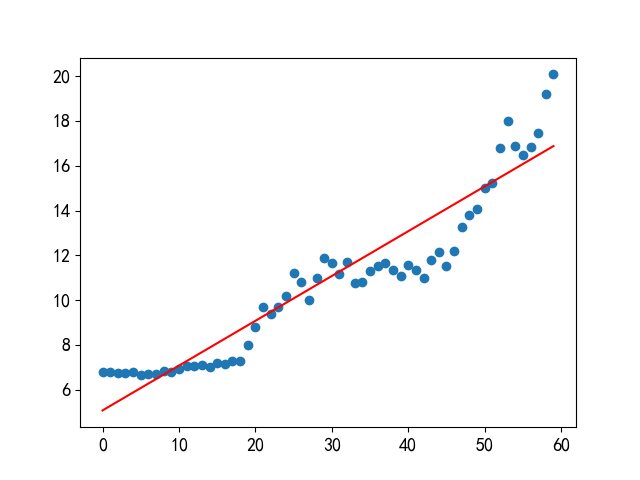

In [527]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [528]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'top10', 'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv',
       'lv'],
      dtype='object', length=112)

### check_postion_vol_price

In [529]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close          vol        amount  \
59  2023-04-04  601360  19.71  20.85  19.45  20.08  551016621.0  1.100956e+10   

     ma5d  ma10d  ...  ma5dcum  ra   hmax   max5   lmin   min5  cmean  \
59  18.01  17.19  ...     16.4   0  14.07  17.98  13.92  13.92  17.49   

             hv          lv  Positon  
59  688141914.0  14862751.0  Neutral  

[1 rows x 113 columns]

In [530]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=113)

0    2023-01-04
1    2023-01-05
2    2023-01-06
Name: date, dtype: object

59   2023-04-04
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.2 


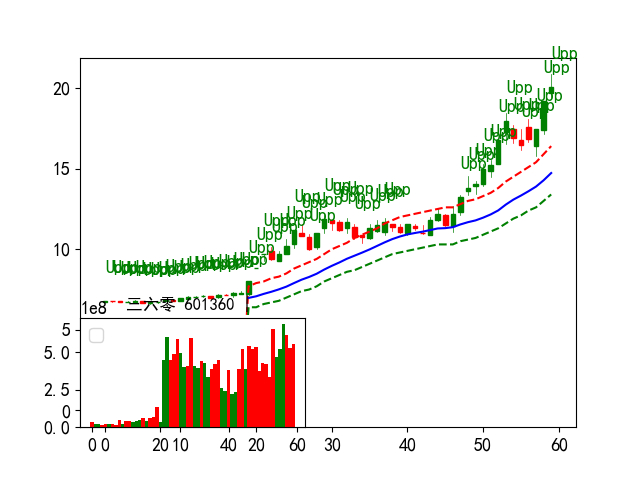

In [531]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'b', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [532]:
'code' in dfc.columns

True

### show_channel_mpl

In [533]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [534]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [535]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'w'

In [536]:
resample = 'w'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5014
3.26 (4962,) 600225 (316, 6)
resample:W
use time:16.45


In [537]:
df.loc['399001'].close.min()
df.groupby(level=[0]).tail(30).groupby(level=[0])

10401.84

## ra_diff

In [538]:
df = df.groupby(level=[0]).tail(30).groupby(level=[0]).apply(ra_diff)


In [539]:
df.loc['999999'][-3:]
df.loc['301073'].ra_diff[-3:]

open       high        low      close          vol  \
date                                                                  
2023-03-26  3282.7390  3282.7390  3260.8444  3265.6537  324513337.0   
2023-04-02  3263.4061  3278.4231  3260.0396  3272.8602  283613746.0   
2023-04-09  3297.1830  3312.5615  3290.9925  3312.5578  385871617.0   

                  amount  ra_diff  
date                               
2023-03-26  4.307616e+11     1.12  
2023-04-02  3.966893e+11     1.12  
2023-04-09  5.558111e+11     1.14

date
2023-03-26    1.18
2023-04-02    1.21
2023-04-09    1.21
Name: ra_diff, dtype: float64

## X df_regression_ratio outdate
    df_idx_detect

In [540]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [541]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [542]:
# df.loc['000002'][-10:]

## sina_dm

In [543]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2023-04-05',
 code
 300028    金亚退
 Name: name, dtype: object)

In [544]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2023-04/06/23 17:20:39'

code
603879   2023-04-06 15:00:01
300045   2023-04-06 15:00:03
Name: ticktime, dtype: datetime64[ns]

140.6027939915657

### Combine ratio and idx

if 'date' in df.columns:
    print('error duplicated date col')
    if isinstance(df,pd.MultiIndex):
        df.drop('date', axis=1, inplace=True)
else:
    df = df.reset_index().set_index('code')
    df['idx'] = df_idx_detect
    df['xratio'] = df_reg_ratio
    df['name'] = sina_dm.name
    df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [545]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [546]:
# tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
# h5.loc[code_muti][:2]

freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf['amount']=mdf['volume'].apply(lambda x: round(x /100,2)) 
mdf['vol']=(mdf.volume / mdf.close).map(lambda x: round(x/100, 2))
mdf['volume'] = mdf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')

['/all_10']
G:\sina_MultiIndex_data.h5


(1478027, 6)

12796.136337863

In [547]:
mdf.loc['000002']

ticktime    2023-04-07 00:00:00
close                 15.054512
volume                     0.09
amount             119452109.74
vol                  7934638.56
Name: 000002, dtype: object

###  实时成交量个股Top

In [548]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [549]:
nowdf.shape,top20_nd

((4941, 5),
         volume   name
 code                 
 600839    0.88   四川长虹
 601360    0.87    三六零
 300459    0.85    汤姆猫
 601728    0.78   中国电信
 601390    0.73   中国中铁
 601288    0.63   农业银行
 000617    0.62   中油资本
 600050    0.58   中国联通
 300059    0.53   东方财富
 000725    0.50   京东方Ａ
 601868    0.50   中国能建
 600667    0.50   太极实业
 002602    0.50   世纪华通
 000021    0.46    深科技
 300303    0.43   聚飞光电
 601138    0.39   工业富联
 601899    0.39   紫金矿业
 002195    0.38   二三四五
 601186    0.37   中国铁建
 000100    0.36  TCL科技)

### 合并实时成交量及SinaDM

In [550]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp   now  trade  high  low   buy  sell   volume  ...  \
code                                                                     ...   
603817  海峡环保  5.88    5.88  5.86    0.0  5.89  5.8  5.85  5.86  3734800  ...   

        close     nvol         timel  lastbuy  nlow  nhigh  nclose  nstd  \
code                                                                       
603817   5.86  3734800  1.680742e+09     5.85  5.84   5.89    5.83  -2.0   

               vol     amount  
code                           
603817  1233628.06  7197516.0  

[1 rows x 44 columns]

## check HDF LastDate

In [551]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4962, 7)

In [552]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high        low      close          vol  \
code   date                                                                 
999999 2023-04-09  3297.183  3312.5615  3290.9925  3312.5578  385871617.0   

                         amount  ra_diff  
code   date                               
999999 2023-04-09  5.558111e+11     1.14

In [553]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [554]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [555]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [556]:
dfs=init_MulitiData_Roll(df,resample=resample)

In [557]:
# dfs.loc['000002'][-5:]

In [558]:
# dfs.loc['688027']
dfs['ma51d'] = round(dfs['close'].rolling(5).mean(), 2)
show_tdx_data(dfs.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 28


ra_diff     hat    close  volsum5d     hmax     lmin  perc1d  \
date                                                                       
2023-04-02     1.36  451.79  1820.00      86.3  1898.25  1473.07    2.33   
2023-04-09     1.36  398.19  1814.59      93.6  1898.25  1488.09   -0.30   

               ma20   vol1d   vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  \
date                                                                       
2023-04-02  1740.44  114.93  -52.74  27.70  30.64 -34.25    4.00    1.79   
2023-04-09  1755.86  -26.89  114.93 -52.74  27.70  30.64    4.17   -0.19   

              ma51d  ra_diff  
date                          
2023-04-02  1781.73     1.36  
2023-04-09  1781.04     1.36

### Append Now SinaTo MultiIndex dfNow

In [559]:
cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    sina_today=sina_dm.copy()
    if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
        sina_today['date']=pd.to_datetime(cct.get_today())
        print('concat1 init:sina_today:%s'%(sina_today.index[0]))
        # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
        # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
        # sina_today['idx'] = df_idx_detect2
        # sina_today['xratio'] = df_reg_ratio2
        # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
        if 'vol' in sina_today.columns:
            sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
        else:
            sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

    if sina_today.index[0] not in df.index:
        # df.index=df.index.append(sina_dm.index)
        print('concat1:sina_today:%s %s'%(sina_today.index[0]))
        df = pd.concat([df, sina_today])


#         sina_today=sina_dm.copy()
#         #drop line and append idx
#         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
#             sina_today['date']=pd.to_datetime(cct.get_today())
#             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

#             sina_today['idx'] = df_idx_detect2
#             sina_today['xratio'] = df_reg_ratio2
#             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
#             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


#         df = get_multiIndex_drop_last_row(df,dropline=1)

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat2:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])
        df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfNow=get_Append_Sina_To_MultiTDX(dfs.groupby(level=[0]).tail(30),sinadm)
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfs.groupby(level=[0]).tail(30).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df.loc[code_df][-2:]


'2023-04-06'

In [560]:
# dfNow.loc['000002']

### Xratio and tail 30 MultiIndex 

In [561]:
# dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
df_xratio.index =df_xratio.to_frame().index.droplevel(1)
dfNow['xratio'] = df_xratio

In [562]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2023-04-02    7.72
2023-04-09    8.42
Name: upper, dtype: float64

xratio:0.14 ra_diff:2.86


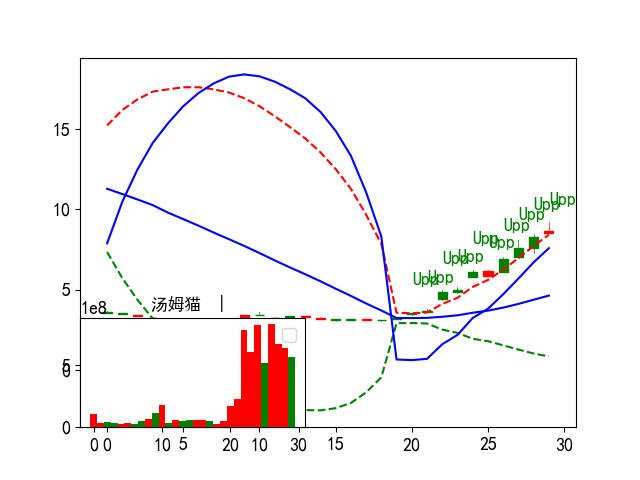

In [563]:
dfNow.loc['300459'][-2:].upper
show_ohlc_upper(dfNow.loc['300459'][-30:],code='300459')

600839 1.95
xratio:0.04 ra_diff:1.95


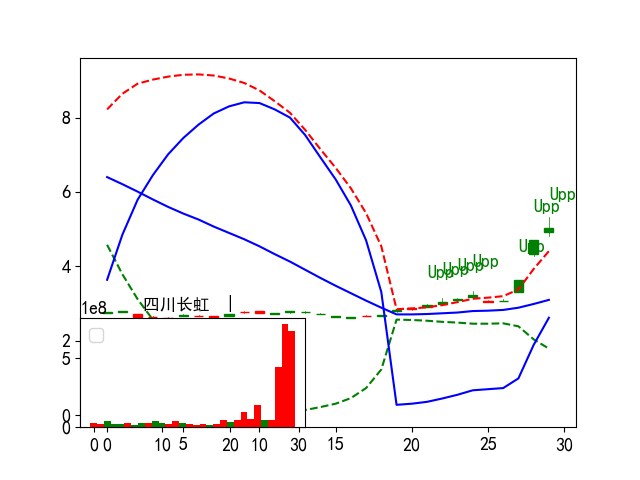

601360 3.09
xratio:0.3 ra_diff:3.09


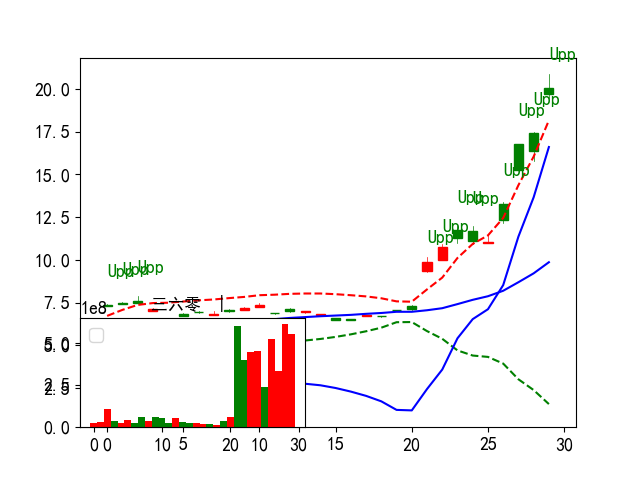

300459 2.86
xratio:0.14 ra_diff:2.86


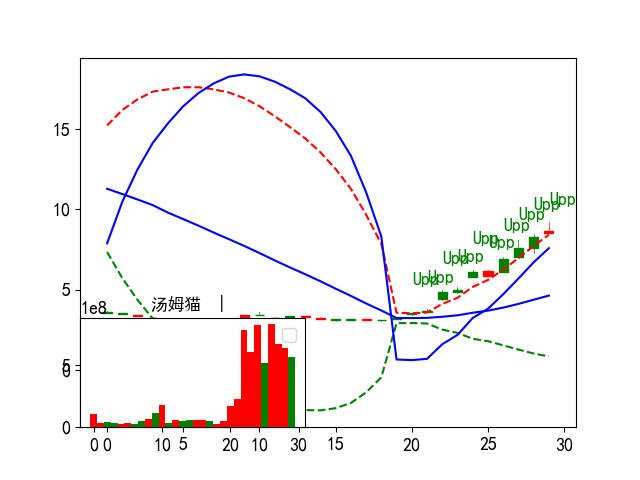

601728 1.9
xratio:0.11 ra_diff:1.9


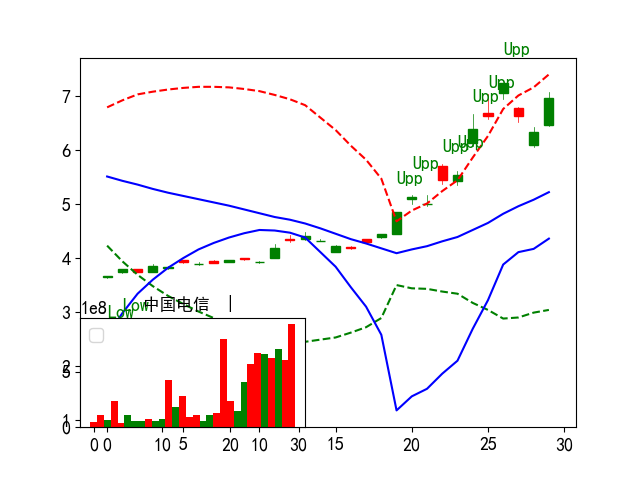

601390 1.51
xratio:0.06 ra_diff:1.51


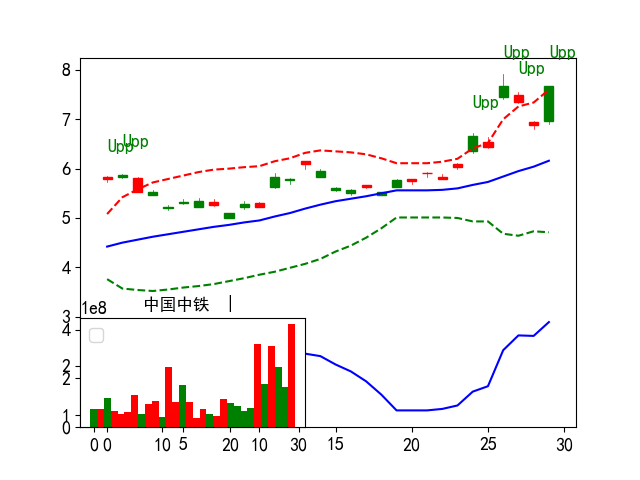

601288 1.15
xratio:0.01 ra_diff:1.15


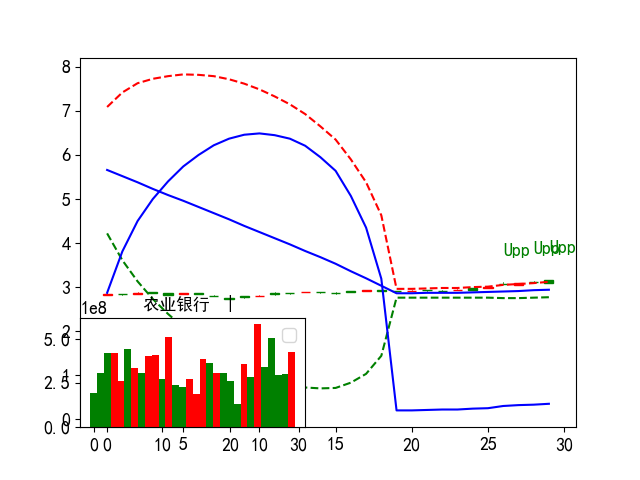

000617 1.73
xratio:0.08 ra_diff:1.73


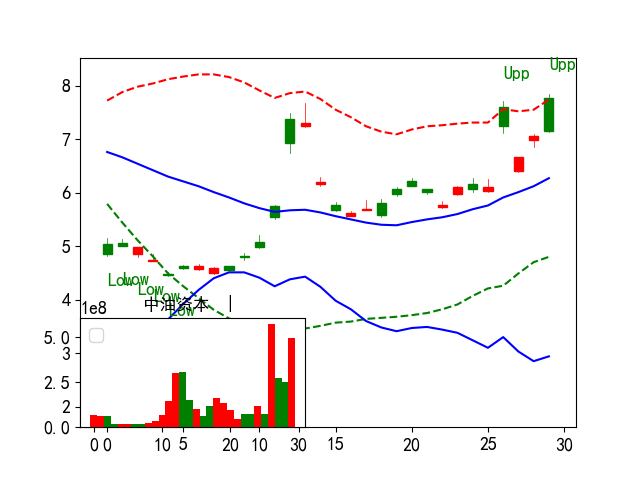

600050 1.74
xratio:0.1 ra_diff:1.74


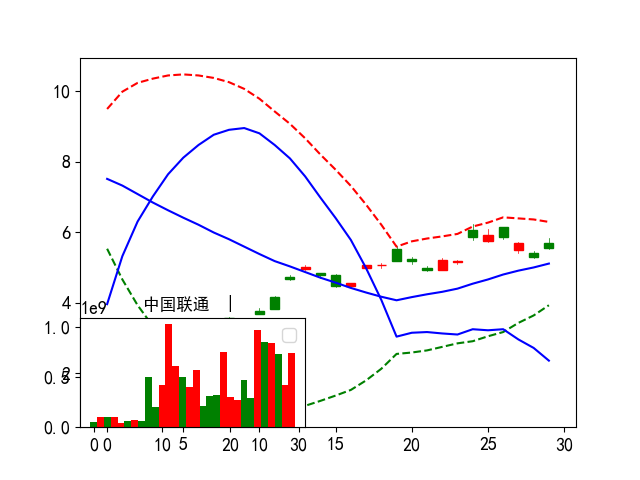

300059 1.48
xratio:0.1 ra_diff:1.48


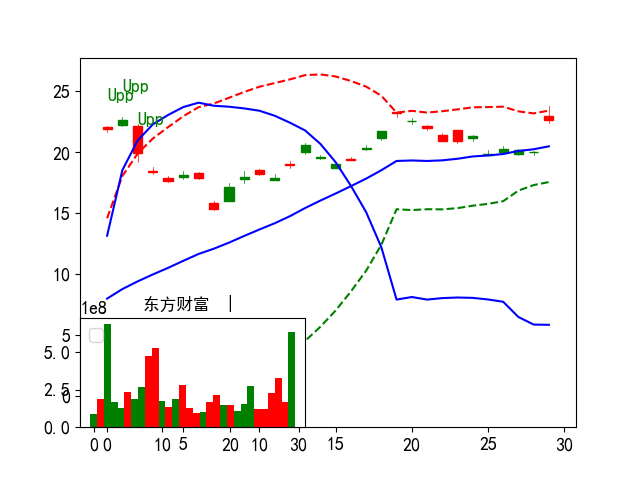

000725 1.35
xratio:0.03 ra_diff:1.35


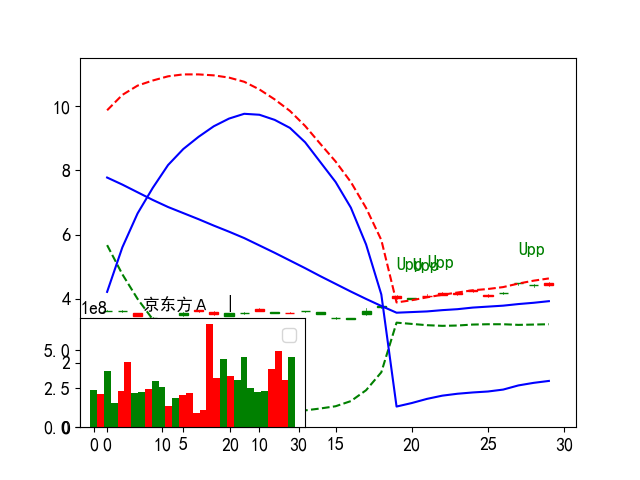

In [564]:
for co in top20_nd.index[:10]:
    print(co,dfNow.loc[co].ra_diff[-1])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfNow.loc[co][-30:],co)

In [565]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date      open       high        low      close          vol  \
code                                                                        
999999 2023-04-09  3297.183  3312.5615  3290.9925  3312.5578  385871617.0   
688981 2023-04-09    54.250    57.9900    54.0100    56.6600  167492359.0   

              amount  ra_diff      ma5     ma10  ...  perc5d   vol1d  vol2d  \
code                                             ...                          
999999  5.558111e+11     1.14  3265.42  3267.07  ...   -0.48   36.06 -12.60   
688981  9.472352e+09     1.50    50.63    46.66  ...   30.79  231.78 -25.33   

        vol3d  vol4d    vol5d  volsum5d    ma51d  xratio    idx  
code                                                             
999999   8.93   5.96   -18.27      20.1  3265.42   12.52  49.15  
688981 -51.76 -92.99  6338.04    6399.7    50.63    0.46  13.33  

[2 rows x 31 columns]

In [566]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [567]:
df.loc['000002'][-2:]

open   high    low  close          vol        amount  ra_diff
date                                                                      
2023-04-02  15.60  15.65  15.15  15.24  134969442.0  2.070646e+09     1.09
2023-04-09  15.38  15.41  15.08  15.15  120547678.0  1.831317e+09     1.08

In [568]:
dfNow.loc['000002'][-2:]

open   high    low  close          vol        amount  ra_diff  \
date                                                                         
2023-04-02  15.60  15.65  15.15  15.24  134969442.0  2.070646e+09     1.09   
2023-04-09  15.38  15.41  15.08  15.15  120547678.0  1.831317e+09     1.08   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                             ...                                       
2023-04-02  15.92  16.81  17.50  ...  -11.50  73.26  10.67  32.20 -37.58   
2023-04-09  15.59  16.47  17.47  ...   -9.88 -10.69  73.26  10.67  32.20   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-04-02  63.39     141.9  15.92    0.01 -3.34  
2023-04-09 -37.58      67.9  15.59   -0.01 -2.82  

[2 rows x 30 columns]

# 基础处理

In [569]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2023-03-17 2023-03-31


open   high    low  close         vol        amount  \
code   date                                                               
000001 2023-04-02  12.69  12.77  12.51  12.53  86549166.0  1.092263e+09   
       2023-04-09  12.64  12.72  12.59  12.65  64745722.0  8.177265e+08   

                   ra_diff    ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2023-04-02     1.20  13.11  13.63  13.35  ...   -9.60  39.25 -60.08   
       2023-04-09     1.21  12.78  13.38  13.42  ...  -11.48 -25.19  39.25   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2023-04-02  81.66  24.03  -5.35      79.5  13.11    0.11 -2.60  
       2023-04-09 -60.08  81.66  24.03      59.7  12.78    0.09 -1.67  

[2 rows x 30 columns]

Low:2023-03-17


Timestamp('2023-03-26 00:00:00')

In [570]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(460, 30)
count dd.couts
(code    date      
688787  2023-03-26    3
688525  2023-03-26    3
688521  2023-03-26    3
688485  2023-03-26    3
688365  2023-03-26    3
Name: couts, dtype: int64, (460, 31))
dt_low:2023-03-17 df:164 Index(['688787', '688525', '688521', '688485', '688365'], dtype='object', name='code') df_idx:651
Main Down dd :0 MainUP df:164 couts std:0.8 
time: 0.01  164


In [571]:
dfs_dtlen.loc['002987'][-1:]

open   high   low  close         vol        amount  ra_diff  \
date                                                                       
2023-04-09  33.51  35.12  33.5   34.5  12268139.0  4.225694e+08     1.56   

              ma5   ma10   ma20  ...  perc5d   vol1d  vol2d  vol3d   vol4d  \
date                             ...                                         
2023-04-09  32.98  31.66  29.97  ...   15.04  115.09 -28.27 -63.71  428.57   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-04-09 -50.55     401.1  32.98    0.14  3.65  

[1 rows x 30 columns]

## 最近30天筛选

In [572]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(30)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [573]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(11155, 30)
count dd.couts
(code    date      
600271  2022-09-04    14
Name: couts, dtype: int64, (11155, 31))
(code    date      
600271  2023-03-12    14
300739  2023-04-09    13
Name: couts, dtype: int64, (1226, 31))
Count:1226 31


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
605266 2023-03-19      1     2.12    1.61  1.93  38.00  89.49     340.8   
002568 2023-04-09      1     2.01    0.37  5.02   8.73  42.41      81.7   
300659 2023-03-26      2     1.95    0.43  2.14   7.60  29.05      75.6   

                    hmax   lmin  perc1d   ma20  vol1d  vol2d  vol3d  vol4d  \
code   date                                                                  
605266 2023-03-19  94.44  54.00   11.24  81.74  85.13 -11.07  11.15 -88.03   
002568 2023-04-09  43.64  34.70    3.67  39.03  65.25 -42.81  35.56  33.09   
300659 2023-03-26  32.88  22.48    0.83  26.88  -1.07  61.46  16.71  61.70   

                    vol5d  perc3d  perc5d  
code   date                                
605266 2023-03-19  343.66    5.78   12.79  
002568 2023-04-09   -9.44    7.15    3.64  
300659 2023-03-26  -63.22    5.67    8.60

In [574]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [575]:
dfs.loc['301073'].ra_diff

date
2022-09-04    1.00
2022-09-11    1.09
2022-09-18    1.16
2022-09-25    1.14
2022-10-02    1.17
2022-10-16    1.17
2022-10-23    1.19
2022-10-30    1.21
2022-11-06    1.48
2022-11-13    1.37
2022-11-20    1.27
2022-11-27    1.25
2022-12-04    1.31
2022-12-11    1.28
2022-12-18    1.31
2022-12-25    1.25
2023-01-01    1.27
2023-01-08    1.23
2023-01-15    1.17
2023-01-22    1.15
2023-02-05    1.11
2023-02-12    1.22
2023-02-19    1.30
2023-02-26    1.26
2023-03-05    1.38
2023-03-12    1.37
2023-03-19    1.25
2023-03-26    1.18
2023-04-02    1.21
2023-04-09    1.21
Name: ra_diff, dtype: float64

xratio:-0.02 ra_diff:1.08


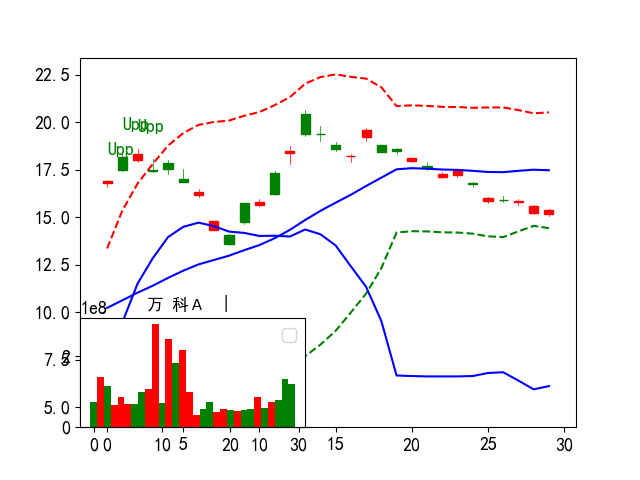

605266 1.86
xratio:1.44 ra_diff:1.86


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


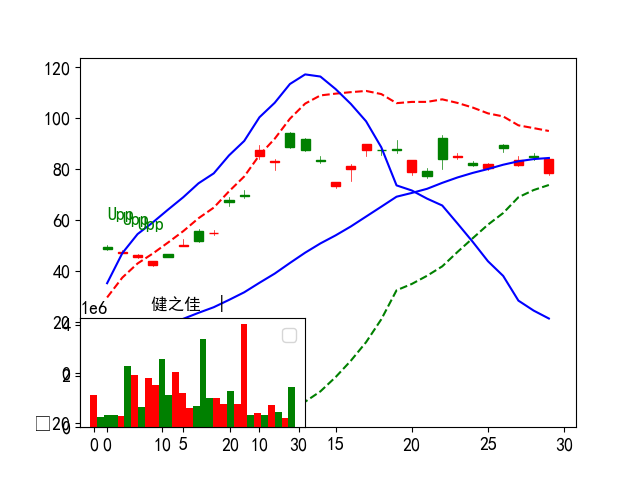

002568 2.01
xratio:0.61 ra_diff:2.01


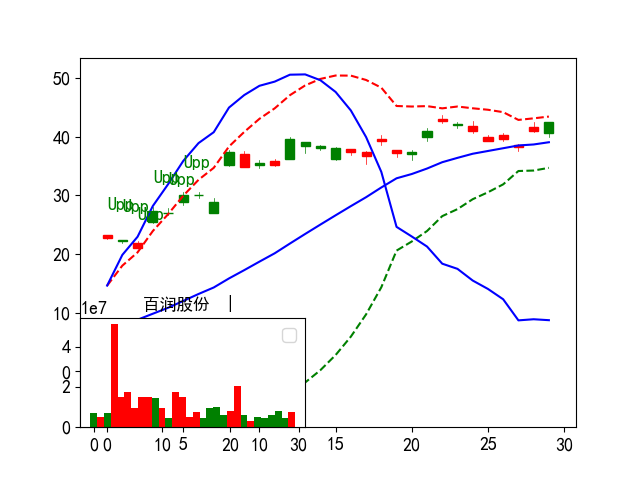

300659 2.21
xratio:0.49 ra_diff:2.21


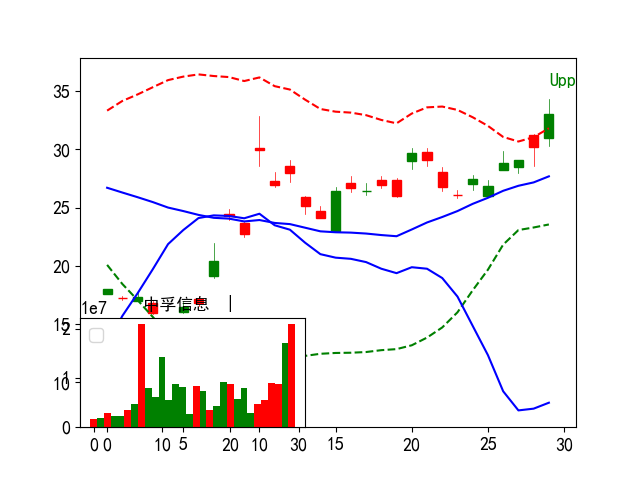

300799 2.45
xratio:2.53 ra_diff:2.45


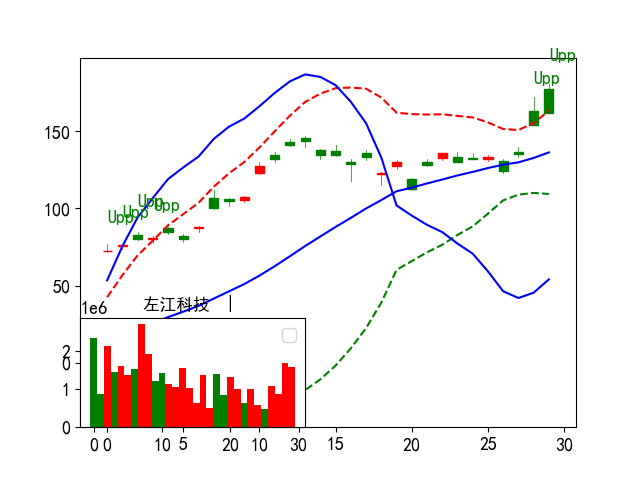

603232 1.86
xratio:0.24 ra_diff:1.86


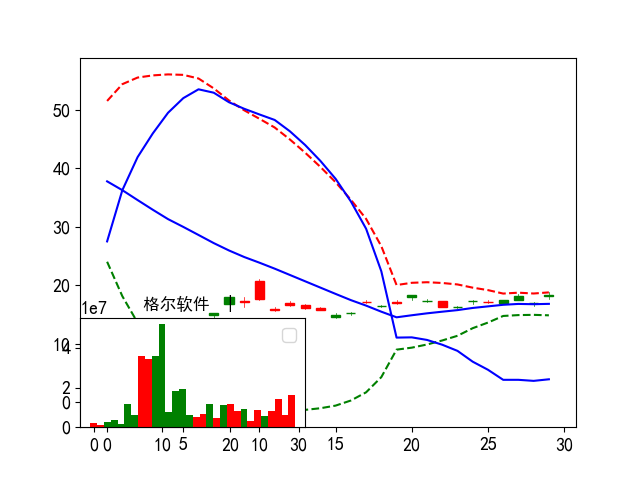

002474 1.81
xratio:0.13 ra_diff:1.81


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


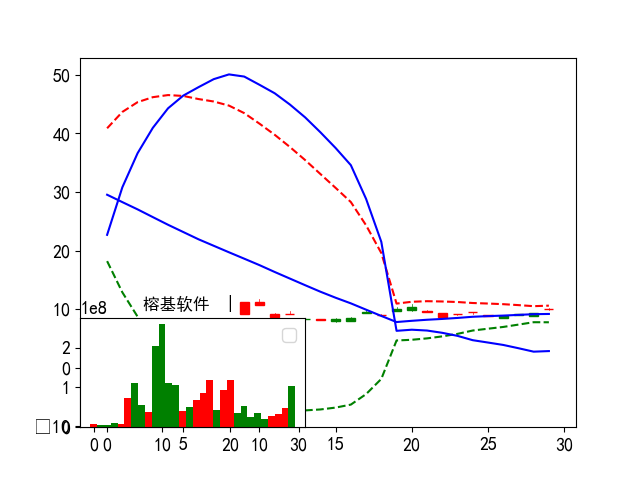

002642 1.74
xratio:0.12 ra_diff:1.74


G:\Temp\ipykernel_4680\4227828802.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


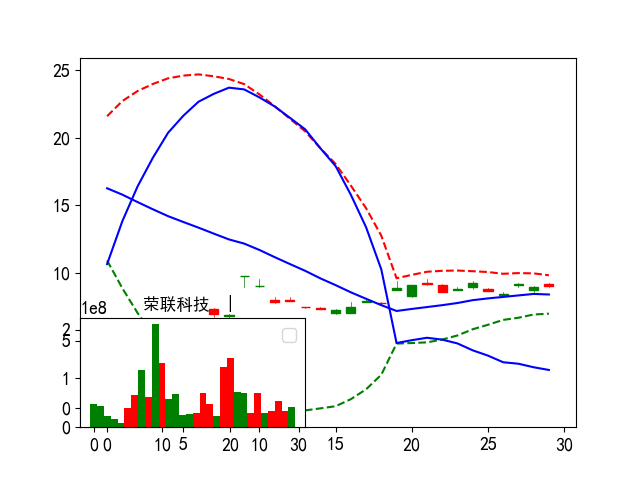

003007 1.78
xratio:0.41 ra_diff:1.78


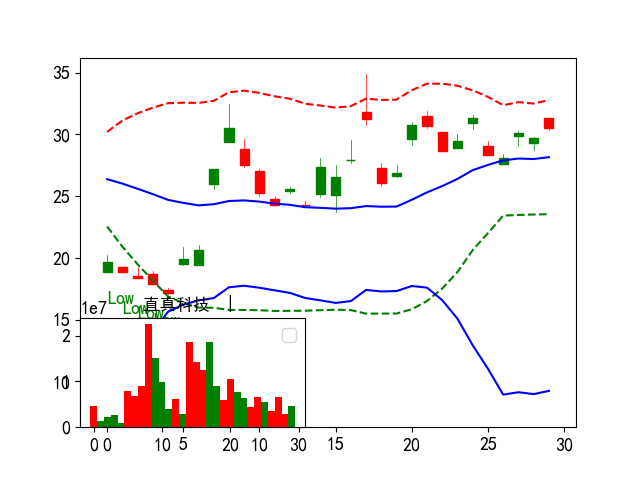

601882 1.7
xratio:0.39 ra_diff:1.7


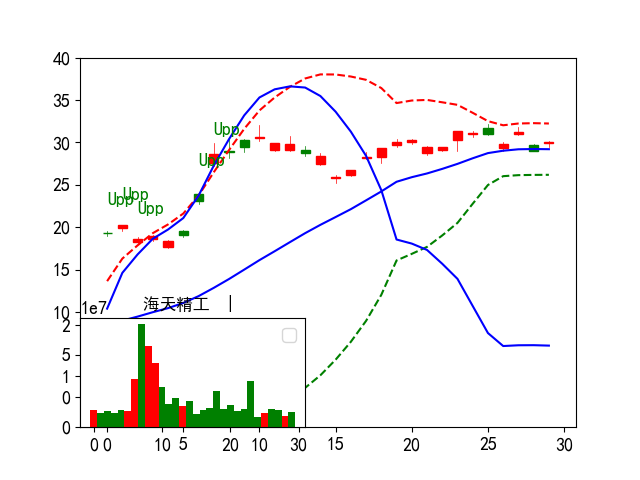

300253 2.19
xratio:0.18 ra_diff:2.19


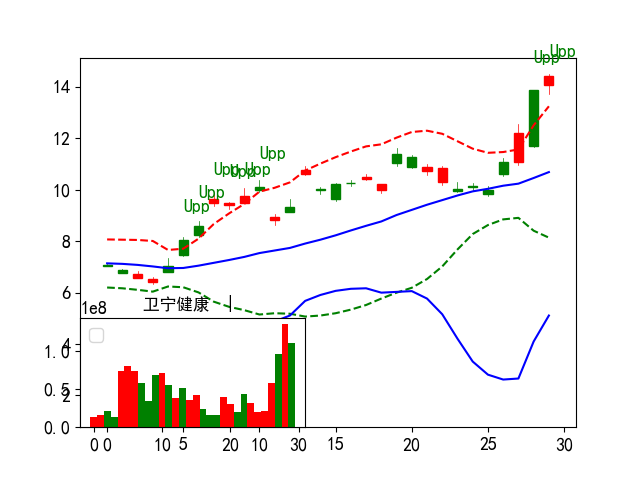

In [576]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfs.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 最近15天数据

In [577]:
dfs_tail9 = dfs.groupby(level=[0]).tail(15)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [578]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2023-03-26    1.12
        2023-04-02    1.12
        2023-04-09    1.14
399001  2023-03-26    1.12
        2023-04-02    1.13
        2023-04-09    1.14
399006  2023-03-26    1.05
        2023-04-02    1.07
        2023-04-09    1.08
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [579]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:15 30


ra_diff  xratio   idx   hat  close  volsum5d   hmax   lmin  \
date                                                                     
2023-04-02     1.22    0.08  1.69  4.74  13.42    -121.4  15.88  10.94   
2023-04-09     1.22    0.08  1.34  4.79  13.41     -89.4  15.88  10.94   

            perc1d   ma20  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                          
2023-04-02   -5.16  12.58 -55.29 -30.59 -10.55 -30.77   5.75   -5.82   -1.83  
2023-04-09   -0.07  12.62  37.84 -55.29 -30.59 -10.55 -30.77   -3.04  -12.24

## Run-Filter强势Upper

### filterRule test

In [580]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



9 0.2 1.84


'Bull'

1.84

date
2023-03-12    0.10
2023-03-19    0.12
2023-03-26    0.13
2023-04-02    0.13
2023-04-09    0.14
Name: xratio, dtype: float64

xratio:0.11 ra_diff:1.9


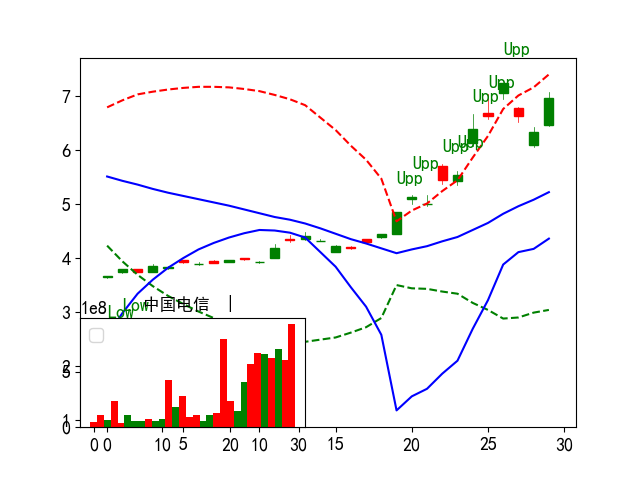

In [581]:
code_filter = '601728'


# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfs.loc[code_filter][-60:], code=code_filter)



In [582]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

xratio:0.14 ra_diff:1.41


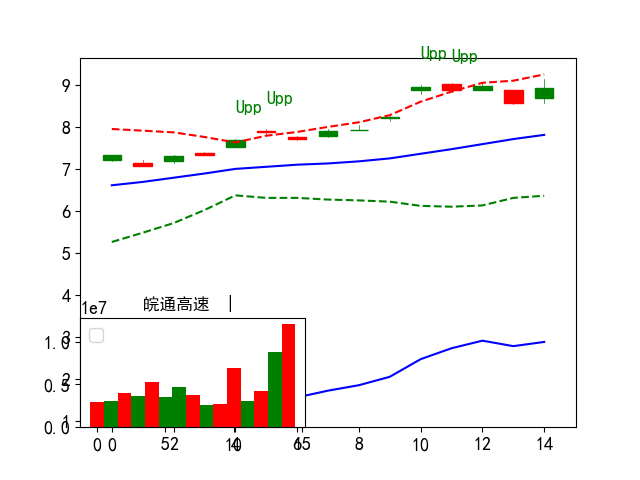

In [583]:
code='600012'
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfs_tail9.loc[code],code=code)

In [584]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 000988    12
 Name: couts, dtype: int64,
 (1141, 40))

Count:1141 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
000988  华工科技     12 2023-04-09   3.90     1.87    0.32  11.56  14.00  31.95   
300494  盛天网络     12 2023-04-09  -5.88     2.32    0.50  15.14  21.03  29.63   
600489  中金黄金     12 2023-04-09   4.50     1.51    0.12   2.09   3.65  11.38   
300389   艾比森     12 2023-04-09  16.18     1.81    0.24   4.33   7.83  18.38   
300275   梅安森     12 2023-04-09  -2.40     2.15    0.47   6.41  15.23  22.39   
...      ...    ...        ...    ...      ...     ...    ...    ...    ...   
603173   福斯达      2 2023-04-09   0.76     1.01    0.00   0.00  30.86  25.29   
000686  东北证券      2 2023-04-09  -0.73     1.08    0.00  -0.10   0.79   6.84   
601162  天风证券      2 2023-04-09  -0.67     1.09    0.00  -0.10   0.30   2.96   
002157  正邦科技      1 2023-04-09  -2.86     1.08   -0.05  -0.13   1.55   3.40   
000971  ST高升      1 2023-04-09   0.00     1.07   -0.00   0.02   0.32   1.89   

        volsum5d  ...   ma20  nclose   llow   vol1d   vol2d  vol3d   vol4d  \
code              ...                                                        
000988     399.5  ...  19.78   32.26  29.34  232.26   33.42  54.77  129.22   
300494     302.4  ...  18.26   29.98  31.02  -28.81  -28.54  -8.13  368.48   
600489     273.0  ...   8.75   11.41  10.33  -27.19  119.04 -22.84    8.49   
300389     204.3  ...  11.53   17.35  13.91  107.64   79.15  -7.86   68.14   
300275     142.3  ...  15.58   22.32  22.48   34.77   46.73  81.62  -24.57   
...          ...  ...    ...     ...    ...     ...     ...    ...     ...   
603173      35.5  ...  10.94   25.15  24.98   58.00  -40.33 -55.09   43.47   
000686      15.8  ...   6.81    6.85   6.84   69.19  -40.58  11.37  -30.67   
601162      -4.0  ...   2.98    2.96   2.96   81.61  -33.04 -22.42   -9.53   
002157     321.9  ...   3.79    3.41   3.35  258.26   56.28  -7.23  -10.36   
000971     105.9  ...   1.89    1.89   1.87  108.13  -46.84  43.87    6.67   

         vol5d  perc3d  perc5d  
code                            
000988  -50.18   43.69   47.13  
300494   -0.60   41.42   82.81  
600489  195.50   11.58   24.32  
300389  -42.78   16.58   22.92  
300275    3.73   21.63   20.67  
...        ...     ...     ...  
603173   29.42   -8.46  265.89  
000686    6.47    2.38   -0.58  
601162  -20.63    1.36   -2.30  
002157   24.92    7.69    0.29  
000971   -5.92    4.42    1.07  

[1141 rows x 23 columns]

#### hmax Top upper > 1

In [585]:
# dfs_tail9.loc['600103']

In [586]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )

count dd.couts
compute percent
code
600228    3
Name: couts, dtype: int64 (266, 40)


(code
 600228    3
 Name: couts, dtype: int64,
 (266, 40))

Count:226 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
600228  返利科技      3 2023-04-09  -9.98     2.31    0.21   6.84   8.76  12.99   
601595  上海电影      6 2023-04-09   9.72     2.47    0.34  10.69  13.50  22.91   
300538  同益股份      4 2023-04-09   0.68     1.69    0.20   5.23   8.23  17.65   
002611  东方精工      2 2023-04-09   3.36     1.28    0.02   0.52   1.10   5.23   
603117  ST万林      2 2023-04-09   3.46     1.77    0.06   0.96   1.55   4.19   
...      ...    ...        ...    ...      ...     ...    ...    ...    ...   
300459   汤姆猫      7 2023-04-09 -11.70     2.86    0.21   5.01   7.58   7.55   
300964  本川智能      6 2023-04-09  -6.58     2.39    1.39  28.80  51.98  54.92   
300406  九强生物      3 2023-04-09  -1.31     1.36    0.12   4.65   6.44  21.11   
600088  中视传媒      2 2023-04-09  -2.84     1.45    0.11   1.60   2.52  10.95   
600687   NaN      2 2023-04-09    NaN     1.94    0.02   0.78   1.28   1.92   

        volsum5d  ...   ma20  nclose   llow   vol1d   vol2d  vol3d    vol4d  \
code              ...                                                         
600228    3829.1  ...   8.39   13.57  13.81    1.00  -44.01 -33.89  3895.86   
601595    1875.5  ...  12.05   20.99  20.31   22.85  -18.17 -16.84   -45.39   
300538    1779.4  ...  12.63   17.59  16.49   13.37   15.50  34.84   -52.38   
002611     901.1  ...   4.41    5.13   4.95  -25.43  944.61   1.51    -9.72   
603117     882.3  ...   3.12    4.14   3.95  259.47  102.41   2.51   -10.90   
...          ...  ...    ...     ...    ...     ...     ...    ...      ...   
300459     -11.8  ...   4.63    7.95   8.50  -11.83   -5.24 -19.21    62.34   
300964     -14.3  ...  36.32   59.76  53.88   23.98   -4.38 -10.64   -17.46   
300406     -44.1  ...  18.34   21.12  20.50    4.50    0.88   1.86   -47.02   
600088     -50.7  ...   9.99   11.03  11.18  -19.36   25.04 -23.71     5.17   
600687     -65.4  ...   1.33     NaN   0.00    0.00    0.00   0.00  -100.00   

          vol5d  perc3d  perc5d  
code                             
600228    10.15   44.30   91.89  
601595  1933.00   58.42  100.77  
300538  1768.10   20.15   38.58  
002611    -9.85   15.79   10.24  
603117   528.84   20.90   26.17  
...         ...     ...     ...  
300459   -37.83   24.09   39.71  
300964    -5.84   -4.09   41.32  
300406    -4.33    3.03   11.35  
600088   -37.80    6.02    6.32  
600687    34.58    0.00   92.00  

[226 rows x 23 columns]

In [587]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [588]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:266 40


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
603083   剑桥科技      5 2023-04-09  -6.15     4.96     4.96    0.98  31.81   
300418   昆仑万维      6 2023-04-09   6.83     4.00     4.00    1.22  31.00   
300212    易华录      5 2023-04-09  -3.25     3.71     3.71    0.95  19.35   
300229    拓尔思      5 2023-04-09 -10.24     3.39     3.39    0.88  15.19   
300364   中文在线      5 2023-04-09  -9.75     3.18     3.18    0.45  10.33   
...       ...    ...        ...    ...      ...      ...     ...    ...   
000876  新 希 望      2 2023-04-09   0.42     1.12     1.12   -0.01   0.97   
601398   工商银行      3 2023-04-09   0.22     1.11     1.11    0.01   0.22   
600273   嘉化能源      1 2023-04-09   0.55     1.10     1.10   -0.00   0.41   
002714   牧原股份      1 2023-04-09  -0.95     1.08     1.08   -0.03   0.54   
301297    富乐德      1 2023-04-09   2.18     1.04     1.04    0.00   0.00   

          hat  close  ...   ma20  nclose   llow  vol1d   vol2d  vol3d  \
code                  ...                                               
603083  38.39  42.70  ...  18.22   44.45  43.45   6.46    1.11  54.49   
300418  44.45  52.88  ...  22.08   49.75  48.34 -40.57   24.30  -5.92   
300212  26.77  44.99  ...  27.12   46.00  41.99  85.51  -28.86  40.02   
300229  28.37  30.16  ...  18.77   32.31  32.50 -19.73   -3.93  52.11   
300364  16.13  19.99  ...  12.21   20.45  21.80 -22.31  -19.04  84.99   
...       ...    ...  ...    ...     ...    ...    ...     ...    ...   
000876   1.46  14.21  ...  13.17   14.09  13.91  17.84  484.52 -42.02   
601398   0.36   4.53  ...   4.34    4.52   4.44  30.52   44.83 -52.76   
600273   0.86   9.16  ...   8.68    9.10   9.02  -8.96  300.13 -36.82   
002714   4.31  50.18  ...  48.52   50.30  49.80  -0.50  235.99 -56.27   
301297   8.43  21.57  ...  17.40   21.44  20.83  34.90   -9.13 -34.75   

          vol4d   vol5d  perc3d  perc5d  
code                                     
603083    -9.83  -32.62   91.34   98.69  
300418   162.14  -52.34   81.39   96.98  
300212   -48.79  210.43   45.13   76.60  
300229    -2.82  -29.52   50.00   36.98  
300364    36.32   39.27   72.78   78.77  
...         ...     ...     ...     ...  
000876    -5.62   43.19    8.93    7.12  
601398    54.35  -31.07    0.00    3.67  
600273     6.21    1.56    7.68    2.24  
002714    49.10   43.04    5.63    1.81  
301297  1726.28  -24.26   -2.22   28.48  

[266 rows x 24 columns]

xratio:0.07 ra_diff:1.24


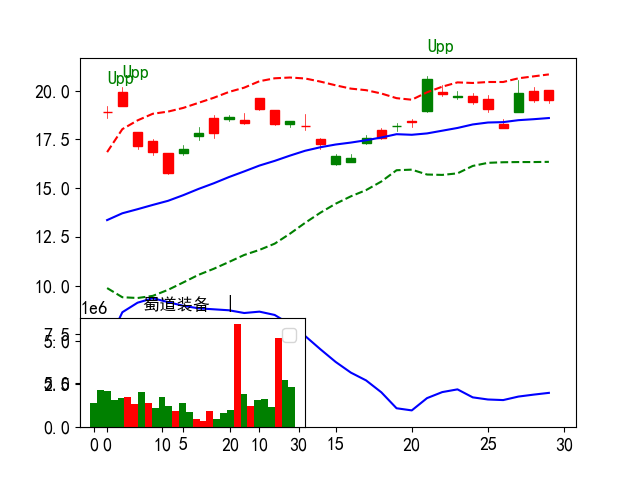

In [589]:
show_ohlc_upper(dfs.loc['300540'][-60:],code='300540')

### df_mask250 upper xratio

In [590]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1])
# show_tdx_data(df_mask250.loc[code_t])

(2686, 30)

count dd.couts
(code    date      
688521  2023-03-05    6
        2023-03-12    6
        2023-03-19    6
Name: couts, dtype: int64, (1127, 31))
compute percent
df_mask250:587 df_mask_hmax:266
cross_hamx:171
Count:218 40


name  couts       date   perc  ra_diff  xratio     idx     hat  \
code                                                                     
603444   吉比特      3 2023-04-09   1.16     2.35    8.61  180.23  233.75   
300033   同花顺      3 2023-04-09  -5.14     2.93    4.15  106.01  145.31   
300474   景嘉微      3 2023-04-09  -2.51     2.76    2.30   64.60   92.11   
605168   三人行      3 2023-04-02 -10.00     2.23    3.07   49.93   94.81   
301205  联特科技      2 2023-04-09  -2.10     2.30    1.70   44.90   63.28   
...      ...    ...        ...    ...      ...     ...     ...     ...   
603169  兰石重装      2 2023-04-02  -1.69     1.27    0.03    1.23    1.52   
000761  本钢板材      2 2023-03-19  -1.07     1.47    0.02    1.16    1.41   
000911  南宁糖业      2 2023-04-09   4.89     1.36    0.06    1.13    1.92   
600737  中粮糖业      2 2023-04-02   1.99     1.22    0.04    0.96    1.32   
601003  柳钢股份      3 2023-03-19  -2.38     1.39    0.04    0.93    1.44   

         close  volsum5d  ...    ma20  nclose    llow   vol1d   vol2d   vol3d  \
code                      ...                                                   
603444  542.10     335.8  ...  365.28  546.87  510.00   29.98    1.94   18.76   
300033  215.30     517.9  ...  124.37  218.83  217.38  -28.19    2.81   43.41   
300474  127.57     199.2  ...   73.58  129.60  127.28   13.47  -40.66  105.48   
605168  138.78     368.5  ...  104.81  144.13  145.70   86.14  -36.56  127.66   
301205   85.21      63.0  ...   53.94   87.93   85.31  -16.97   25.10   75.35   
...        ...       ...  ...     ...     ...     ...     ...     ...     ...   
603169    7.56     261.0  ...    6.81    7.54    7.77    9.22  -35.67   88.11   
000761    3.71     266.2  ...    3.21    3.71    4.12  -39.97   49.79  164.29   
000911    9.66     352.3  ...    8.19    9.65    9.10  -47.32  256.79   46.31   
600737    8.20     403.5  ...    7.28    8.21    7.94  153.60   56.43  -65.46   
601003    4.11     276.6  ...    3.85    4.11    4.60  -26.03  -66.94  345.22   

         vol4d   vol5d  perc3d  perc5d  
code                                    
603444  307.93  -22.82   39.97   42.52  
300033  534.40  -34.51   71.40   82.38  
300474  178.21  -57.32   62.10   63.15  
605168  -40.78  232.08   30.58   47.87  
301205   18.53  -38.97   43.18   34.63  
...        ...     ...     ...     ...  
603169   -2.36  201.69   15.27   14.10  
000761   92.37   -0.30   24.18   32.91  
000911  -65.94  162.44    9.25   12.04  
600737   80.08  178.89    2.67    9.34  
601003   -4.24   28.58   17.13   24.66  

[218 rows x 23 columns]

df_mask250:218
603444 2.35
xratio:7.44 ra_diff:2.35


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


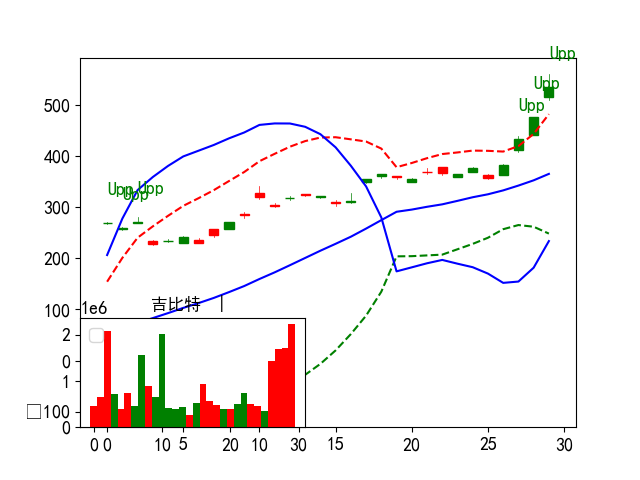

300033 2.93
xratio:3.3 ra_diff:2.93


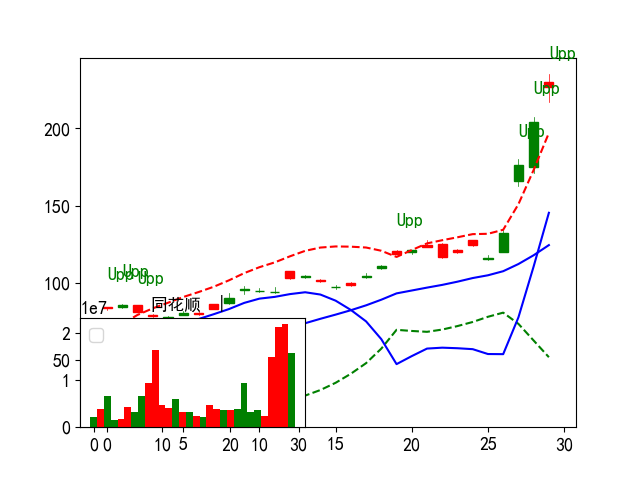

300474 2.76
xratio:1.73 ra_diff:2.76


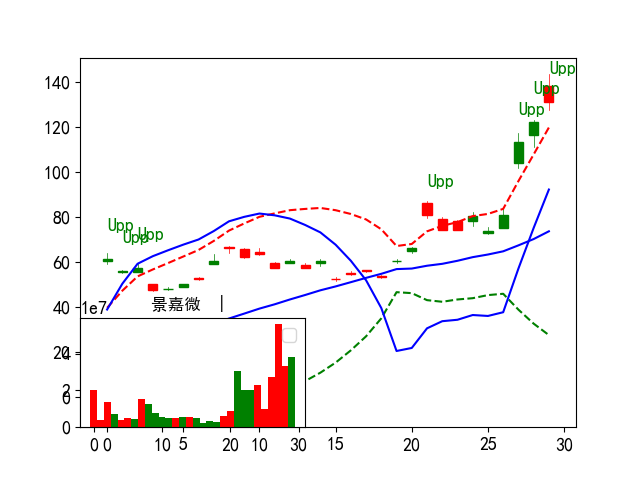

605168 2.2
xratio:2.22 ra_diff:2.2


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


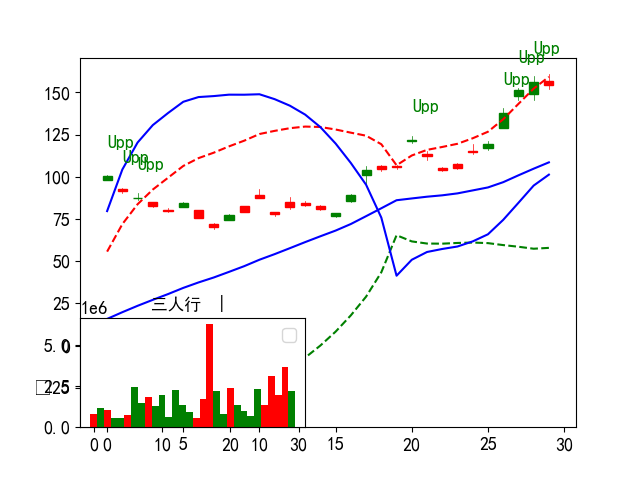

301205 2.3
xratio:1.31 ra_diff:2.3


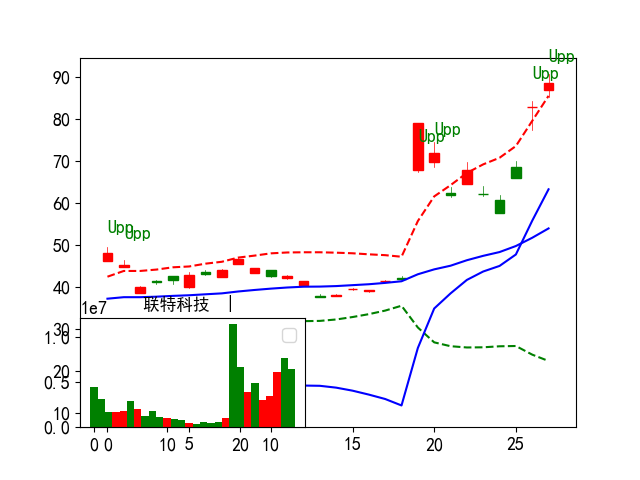

300308 2.57
xratio:0.73 ra_diff:2.57


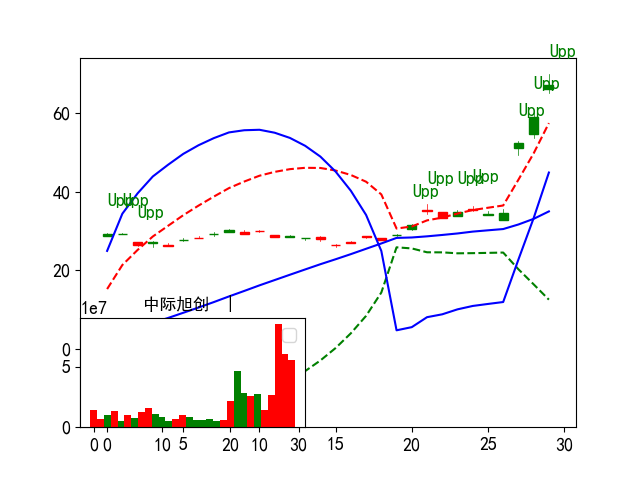

300502 2.92
xratio:0.68 ra_diff:2.92


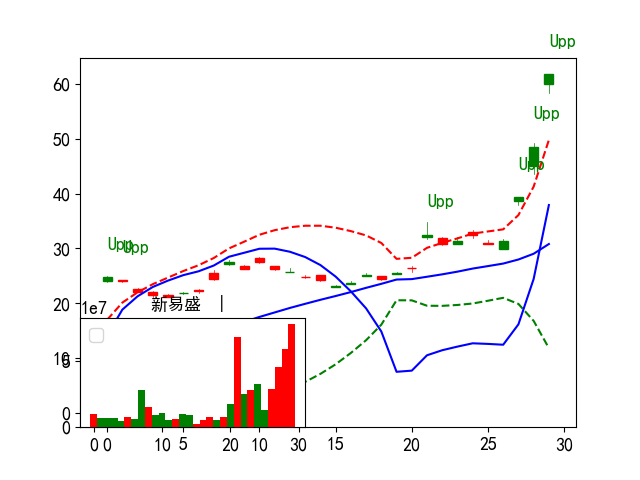

301269 1.52
xratio:0.37 ra_diff:1.52


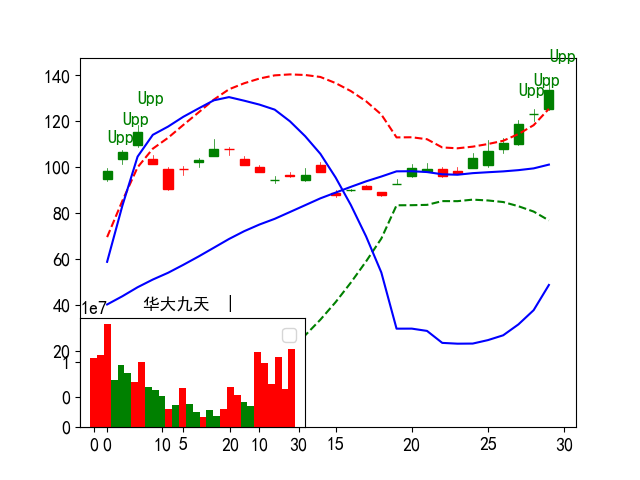

301308 2.02
xratio:0.83 ra_diff:2.02


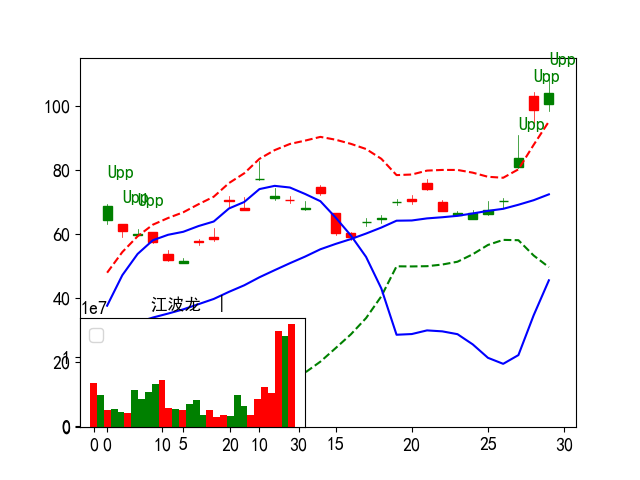

300964 2.39
xratio:0.98 ra_diff:2.39


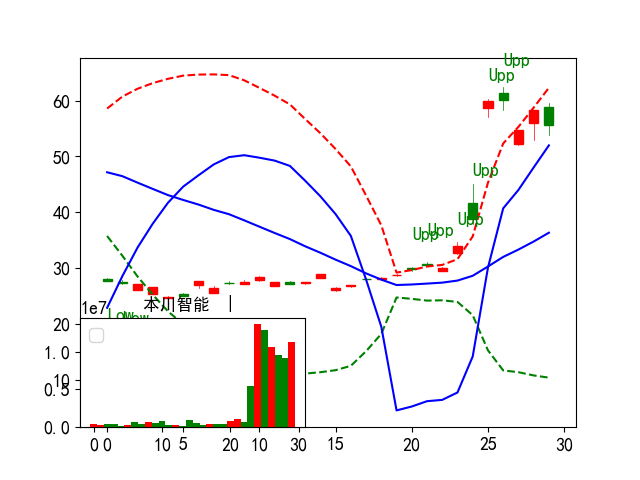

In [591]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [592]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh    llow  close         vol        amount  \
code                                                                         
603444 2023-04-09  515.00  560.00  510.00  542.1   2243529.0  1.217902e+09   
300033 2023-04-09  230.02  234.99  217.38  215.3  15863713.0  3.592096e+09   

        ra_diff     ma5    ma10  ...     idx  couts  nclose  name   open  \
code                             ...                                       
603444     2.35  437.49  401.98  ...  180.23      3  546.87   吉比特  531.0   
300033     2.93  171.20  146.08  ...  106.01      3  218.83   同花顺  215.7   

         high     low  llastp            ticktime  perc  
code                                                     
603444  560.0  523.04  535.88 2023-04-06 15:00:01  1.16  
300033  229.8  208.49  226.97 2023-04-06 15:00:03 -5.14  

[2 rows x 40 columns]

(473, 40)

In [593]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

show_tdx_data(df_masklastd)
show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(587, 40)  lastd:(266, 40) 
Count:266 40


name  couts       date  perc  ra_diff  xratio     idx     hat   close  \
code                                                                            
300308  中际旭创      4 2023-04-09 -0.15     2.57    1.03   35.54   44.83   67.00   
300418  昆仑万维      3 2023-04-09  6.83     4.00    1.22   31.00   44.45   52.88   
300033   同花顺      3 2023-04-09 -5.14     2.93    4.15  106.01  145.31  215.30   
600839  四川长虹      3 2023-04-09 -1.39     1.95    0.06    2.18    2.62    4.97   
300634  彩讯股份      2 2023-03-26 -8.50     2.48    0.40   15.46   17.78   24.76   
...      ...    ...        ...   ...      ...     ...     ...     ...     ...   
000020  深华发Ａ      1 2023-03-26 -0.95     1.33    0.06    1.79    1.96   10.42   
601727  上海电气      1 2023-03-26  2.89     1.17    0.02    0.53    0.65    4.63   
300678  中科信息      2 2023-03-26 -3.35     1.66    0.27    7.54    9.70   24.27   
600835  上海机电      2 2023-03-26 -0.23     1.21    0.06    1.80    2.19   12.90   
600737  中粮糖业      2 2023-04-02  1.99     1.22    0.04    0.96    1.32    8.20   

        volsum5d  ...    ma20  nclose    llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                           
300308     223.0  ...   34.96   70.23   65.01   -8.68  -29.05  217.72   91.53   
300418      87.6  ...   22.08   49.75   48.34  -40.57   24.30   -5.92  162.14   
300033     517.9  ...  124.37  218.83  217.38  -28.19    2.81   43.41  534.40   
600839     712.0  ...    3.10    5.02    4.83   -7.11   72.54  709.18    6.64   
300634     189.3  ...   19.23   24.66   29.25  -18.16  -16.05  238.31   51.92   
...          ...  ...     ...     ...     ...     ...     ...     ...     ...   
000020     590.2  ...    9.74   10.40   10.55  234.15   17.92  -65.39  -76.87   
601727     376.0  ...    4.16    4.60    4.48  -44.95  193.14  -45.34  318.56   
300678     248.3  ...   19.52   24.43   23.54   38.38   19.28  -59.31  280.35   
600835      53.1  ...   12.06   12.85   13.15  -40.53   45.60  -43.91   14.58   
600737     403.5  ...    7.28    8.21    7.94  153.60   56.43  -65.46   80.08   

         vol5d  perc3d  perc5d  
code                            
300308  -48.50   93.87   89.39  
300418  -52.34   81.39   96.98  
300033  -34.51   71.40   82.38  
600839  -69.29   63.64   55.56  
300634  -66.71   62.62   70.24  
...        ...     ...     ...  
000020  480.38    4.25    5.78  
601727  -45.40    4.16    9.47  
300678  -30.44    3.39   19.07  
600835   77.40    2.79   10.40  
600737  178.89    2.67    9.34  

[266 rows x 23 columns]

Count:10 40


name  couts       date  perc  ra_diff  xratio    idx    hat   close  \
code                                                                          
300429  强力新材      4 2023-04-09  2.92     1.37    0.05   1.79   3.12   10.23   
002371  北方华创      1 2023-04-09  8.51     1.30    0.81  30.52  70.09  307.43   
600879  航天电子      2 2023-03-26  0.87     1.41    0.08   1.49   2.11    8.13   
002745   木林森      1 2023-03-26  3.13     1.20    0.04   1.30   1.62    9.87   
300625  三雄极光      1 2023-03-26 -0.80     1.21    0.05   1.55   2.22   12.40   
000020  深华发Ａ      1 2023-03-26 -0.95     1.33    0.06   1.79   1.96   10.42   
601727  上海电气      1 2023-03-26  2.89     1.17    0.02   0.53   0.65    4.63   
300678  中科信息      2 2023-03-26 -3.35     1.66    0.27   7.54   9.70   24.27   
600835  上海机电      2 2023-03-26 -0.23     1.21    0.06   1.80   2.19   12.90   
600737  中粮糖业      2 2023-04-02  1.99     1.22    0.04   0.96   1.32    8.20   

        volsum5d  ...    ma20  nclose    llow   vol1d   vol2d  vol3d   vol4d  \
code              ...                                                          
300429     626.6  ...    8.32   10.16    9.82   76.29  -27.44 -19.92  -28.51   
002371      28.2  ...  243.89  302.19  276.50   77.05  -23.15  18.14  -18.85   
600879     151.0  ...    7.14    8.16    8.18  -51.56  137.56 -35.95   -7.60   
002745      34.0  ...    8.87    9.72    9.54   69.95   10.58  -6.84   16.46   
300625      71.4  ...   11.51   12.40   12.55   65.82    3.22  31.31   39.62   
000020     590.2  ...    9.74   10.40   10.55  234.15   17.92 -65.39  -76.87   
601727     376.0  ...    4.16    4.60    4.48  -44.95  193.14 -45.34  318.56   
300678     248.3  ...   19.52   24.43   23.54   38.38   19.28 -59.31  280.35   
600835      53.1  ...   12.06   12.85   13.15  -40.53   45.60 -43.91   14.58   
600737     403.5  ...    7.28    8.21    7.94  153.60   56.43 -65.46   80.08   

         vol5d  perc3d  perc5d  
code                            
300429  626.19    4.96   22.26  
002371  -24.97    4.94   13.81  
600879  108.55    4.69   11.62  
002745  -56.19    4.63    4.86  
300625  -68.54    4.46    6.39  
000020  480.38    4.25    5.78  
601727  -45.40    4.16    9.47  
300678  -30.44    3.39   19.07  
600835   77.40    2.79   10.40  
600737  178.89    2.67    9.34  

[10 rows x 23 columns]

### df_mask_hmax 061

df_mask_hmax:266
600228 2.31
xratio:0.16 ra_diff:2.31


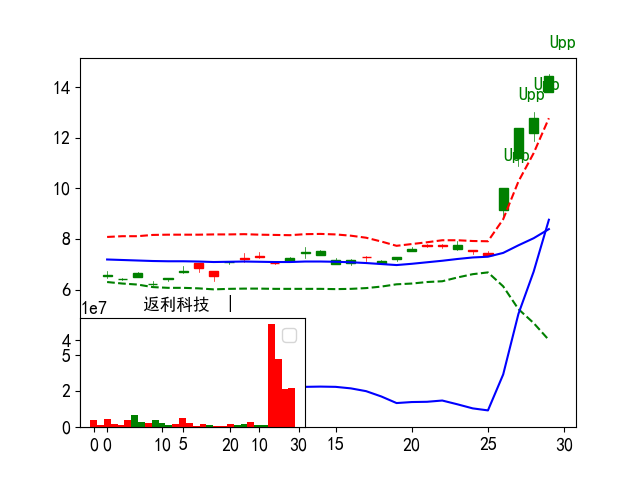

601595 2.47
xratio:0.25 ra_diff:2.47


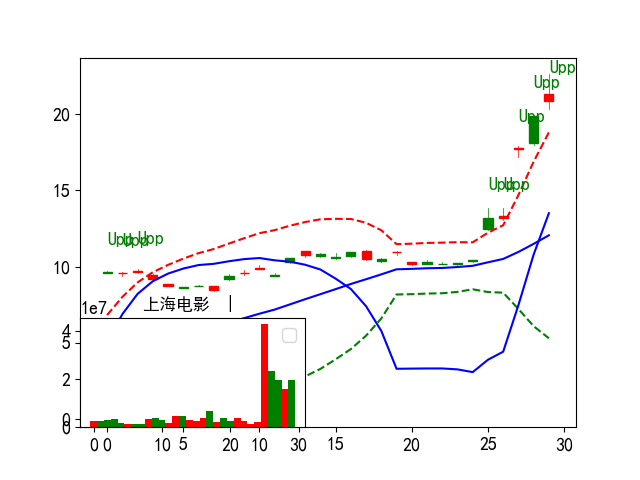

300538 1.69
xratio:0.13 ra_diff:1.69


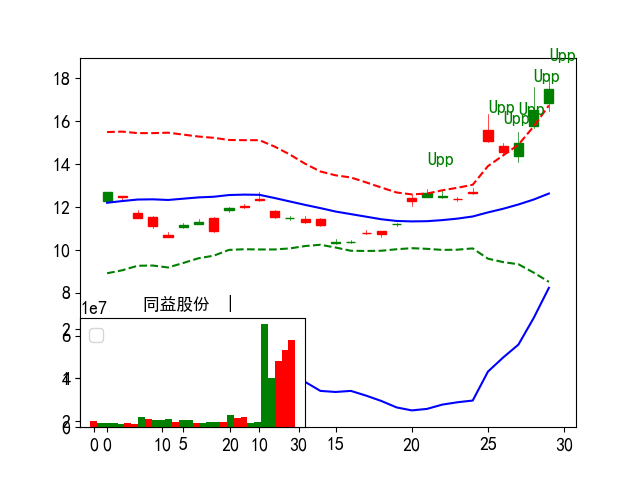

301297 1.04
xratio:-0.02 ra_diff:1.04


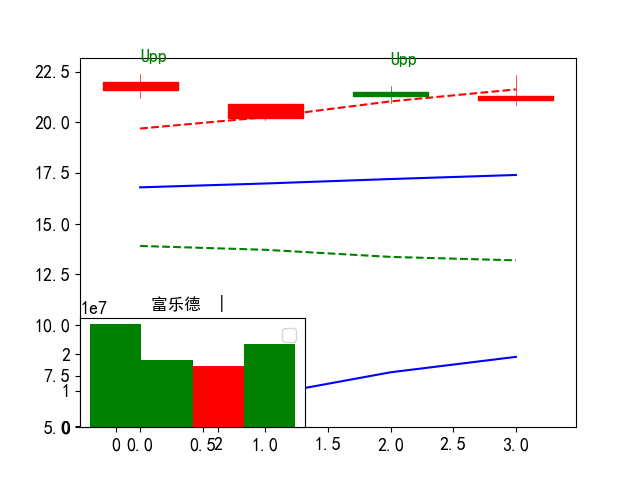

002611 1.28
xratio:0.01 ra_diff:1.28


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


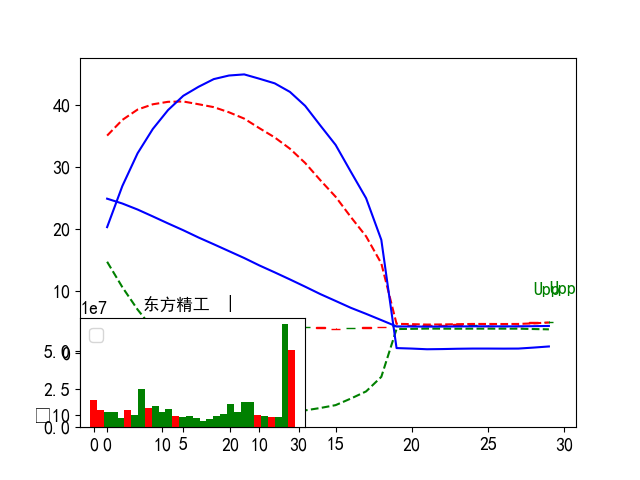

603117 1.77
xratio:0.04 ra_diff:1.77


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


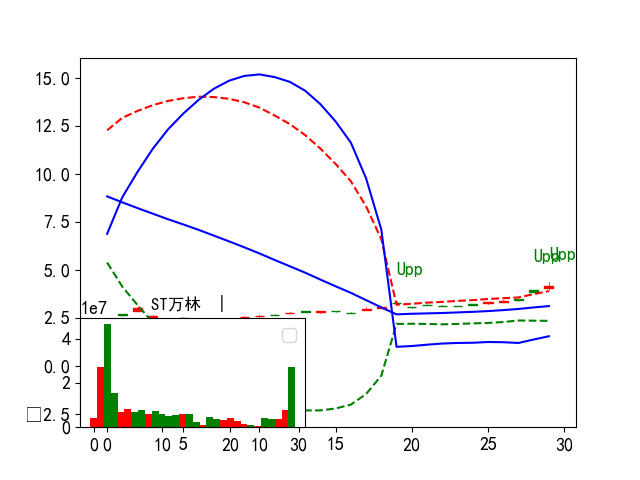

603039 2.43
xratio:1.31 ra_diff:2.43


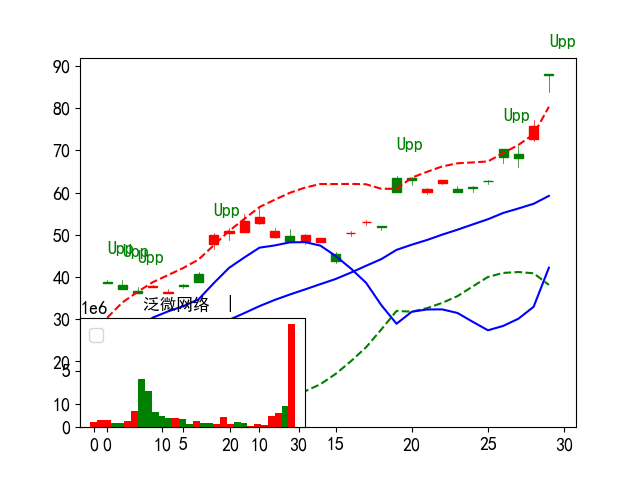

600667 1.41
xratio:0.0 ra_diff:1.41


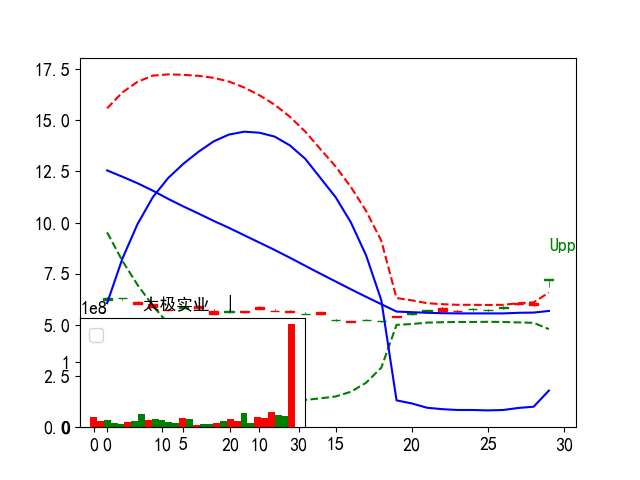

300985 1.48
xratio:0.05 ra_diff:1.48


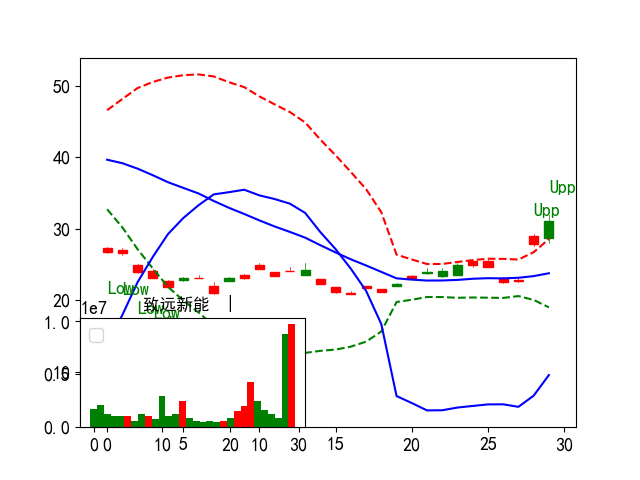

301236 2.03
xratio:0.54 ra_diff:2.03


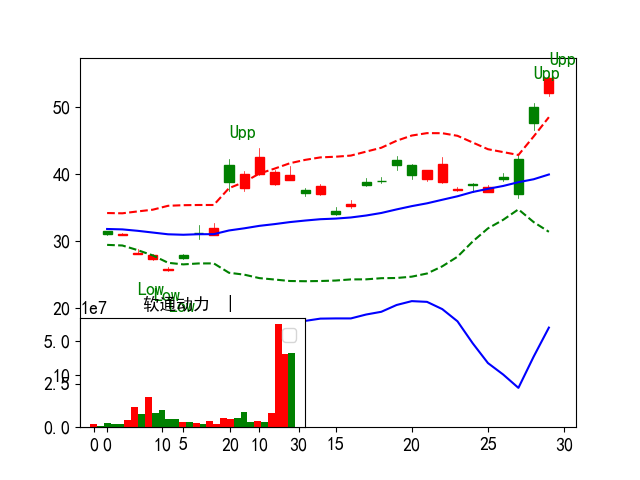

In [594]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:266
300308 2.57
xratio:0.73 ra_diff:2.57


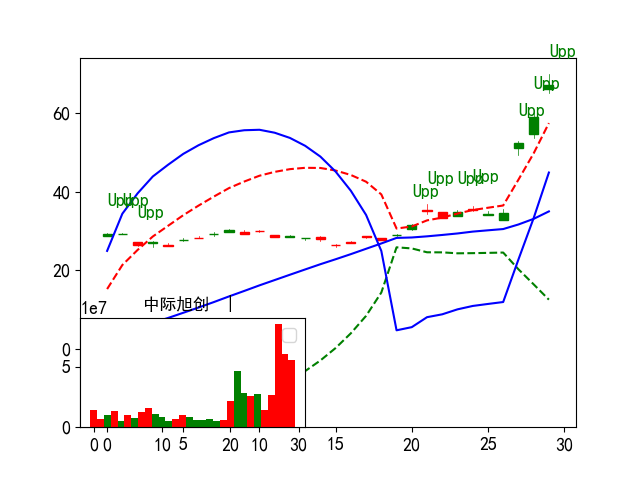

300418 4.0
xratio:0.85 ra_diff:4.0


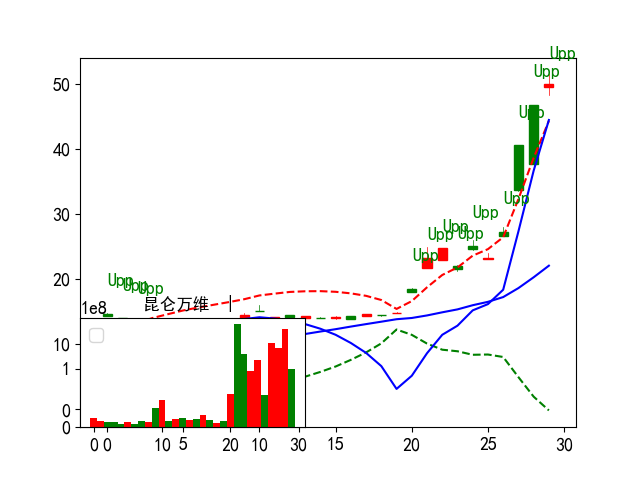

300033 2.93
xratio:3.3 ra_diff:2.93


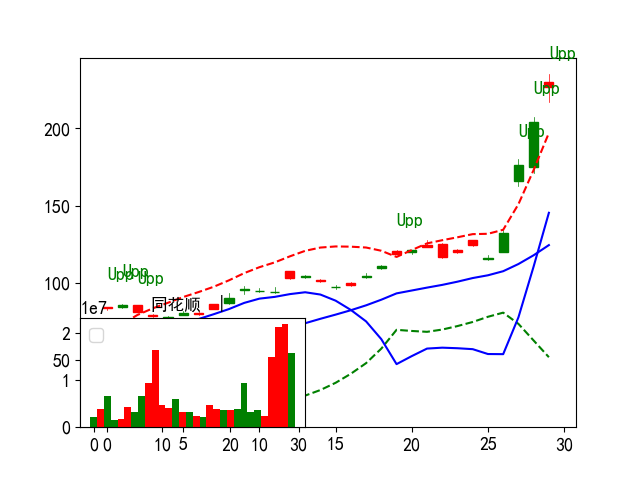

600839 1.95
xratio:0.04 ra_diff:1.95


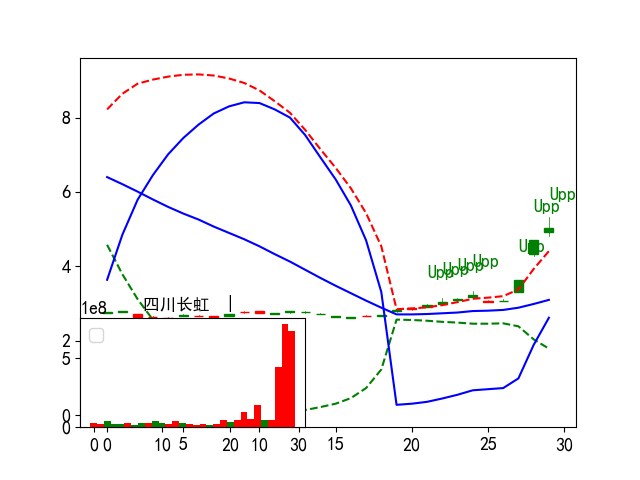

300634 2.13
xratio:0.44 ra_diff:2.13


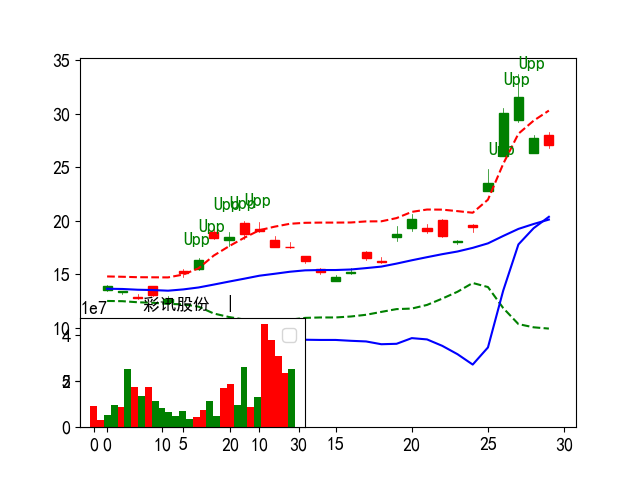

300474 2.76
xratio:1.73 ra_diff:2.76


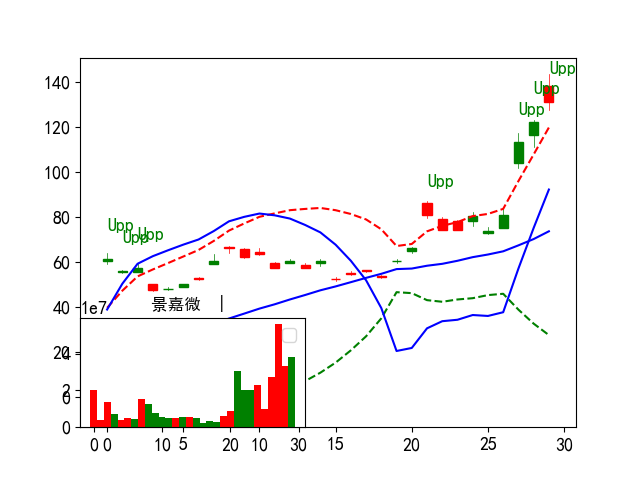

300058 2.08
xratio:0.12 ra_diff:2.08


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


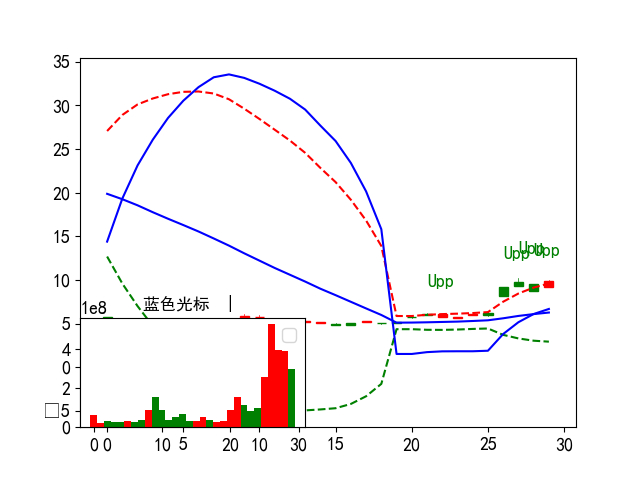

300002 2.88
xratio:0.15 ra_diff:2.88


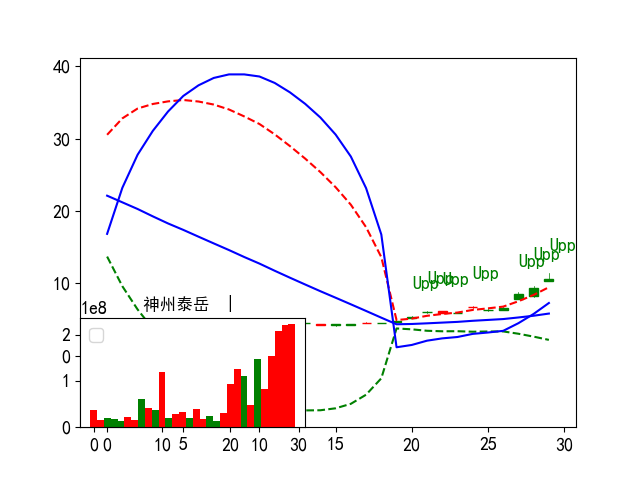

002153 2.2
xratio:0.28 ra_diff:2.2


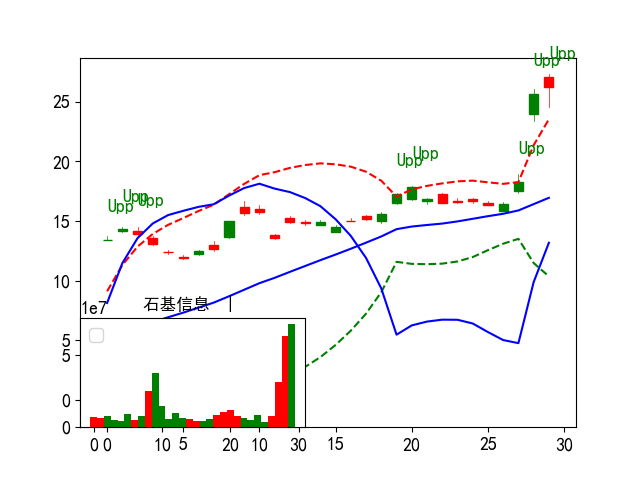

601595 2.47
xratio:0.25 ra_diff:2.47


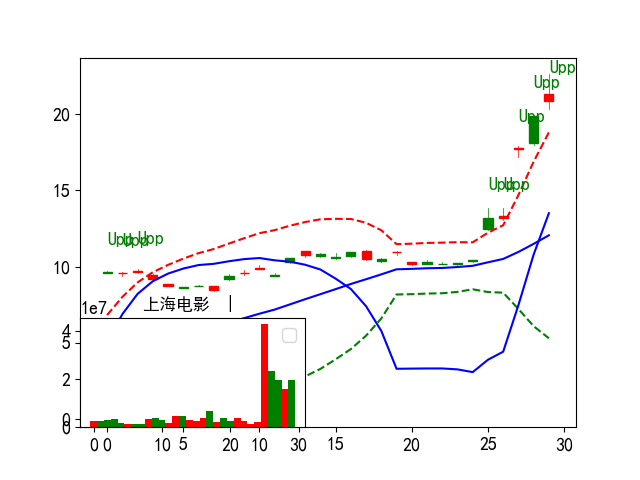

In [595]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [596]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250])

cross_hamx:133
Count:133 40


name  couts       date  perc  ra_diff  xratio     idx     hat   close  \
code                                                                            
300308  中际旭创      4 2023-04-09 -0.15     2.57    1.03   35.54   44.83   67.00   
300418  昆仑万维      3 2023-04-09  6.83     4.00    1.22   31.00   44.45   52.88   
300033   同花顺      3 2023-04-09 -5.14     2.93    4.15  106.01  145.31  215.30   
600839  四川长虹      3 2023-04-09 -1.39     1.95    0.06    2.18    2.62    4.97   
300474   景嘉微      3 2023-04-09 -2.51     2.76    2.30   64.60   92.11  127.57   
...      ...    ...        ...   ...      ...     ...     ...     ...     ...   
002115  三维通信      4 2023-04-09 -4.04     1.78    0.11    2.28    3.84    7.36   
000156  华数传媒      1 2023-03-26 -3.22     1.31    0.08    1.01    1.88    8.71   
600198  大唐电信      2 2023-03-26  1.52     1.36    0.06    1.66    2.03    8.03   
300429  强力新材      4 2023-04-09  2.92     1.37    0.05    1.79    3.12   10.23   
002371  北方华创      1 2023-04-09  8.51     1.30    0.81   30.52   70.09  307.43   

        volsum5d  ...    ma20  nclose    llow  vol1d  vol2d   vol3d   vol4d  \
code              ...                                                         
300308     223.0  ...   34.96   70.23   65.01  -8.68 -29.05  217.72   91.53   
300418      87.6  ...   22.08   49.75   48.34 -40.57  24.30   -5.92  162.14   
300033     517.9  ...  124.37  218.83  217.38 -28.19   2.81   43.41  534.40   
600839     712.0  ...    3.10    5.02    4.83  -7.11  72.54  709.18    6.64   
300474     199.2  ...   73.58  129.60  127.28  13.47 -40.66  105.48  178.21   
...          ...  ...     ...     ...     ...    ...    ...     ...     ...   
002115     109.0  ...    5.55    7.44    7.17  46.10   9.57  -56.48   18.33   
000156      25.0  ...    7.73    8.78    8.59  -7.86  65.79    4.25    7.79   
600198     147.5  ...    6.59    7.96    7.54  -5.26  54.68  -38.10  191.56   
300429     626.6  ...    8.32   10.16    9.82  76.29 -27.44  -19.92  -28.51   
002371      28.2  ...  243.89  302.19  276.50  77.05 -23.15   18.14  -18.85   

         vol5d  perc3d  perc5d  
code                            
300308  -48.50   93.87   89.39  
300418  -52.34   81.39   96.98  
300033  -34.51   71.40   82.38  
600839  -69.29   63.64   55.56  
300474  -57.32   62.10   63.15  
...        ...     ...     ...  
002115   91.43    5.94   30.89  
000156  -44.99    5.56    9.40  
600198  -55.35    5.22   11.99  
300429  626.19    4.96   22.26  
002371  -24.97    4.94   13.81  

[133 rows x 23 columns]

df_mask250:133
600511 1.53
xratio:0.37 ra_diff:1.53


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


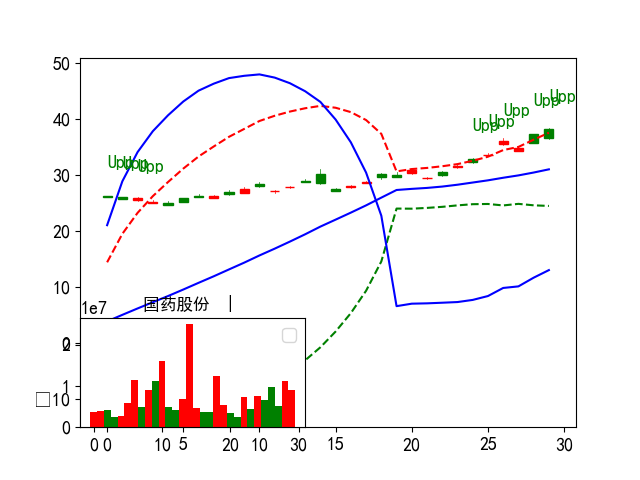

300181 1.83
xratio:0.16 ra_diff:1.83


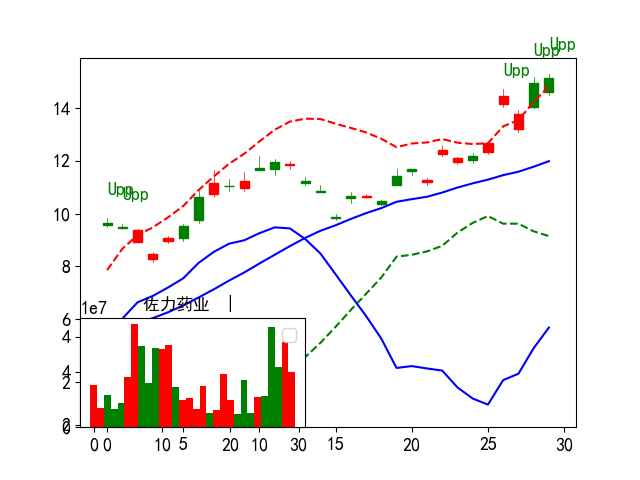

300295 1.45
xratio:0.08 ra_diff:1.45


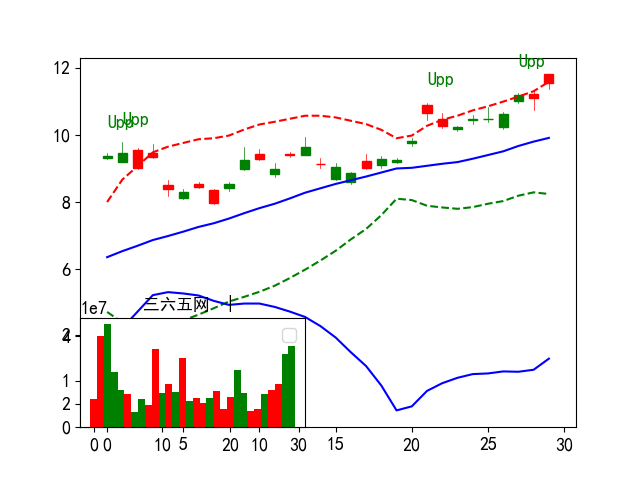

300579 1.94
xratio:0.45 ra_diff:1.94


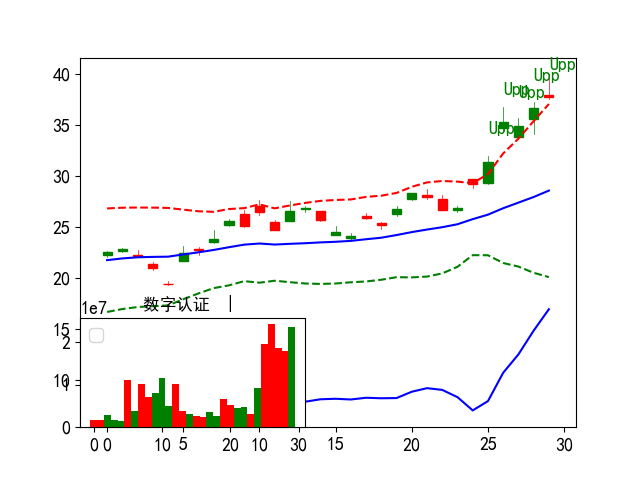

300236 1.49
xratio:0.25 ra_diff:1.49


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


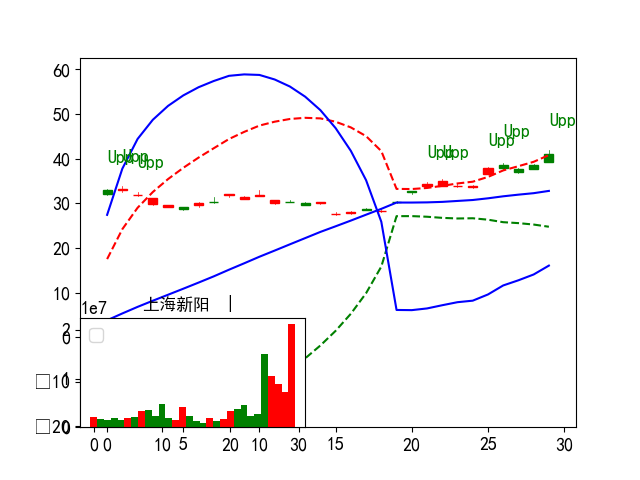

002115 1.78
xratio:0.07 ra_diff:1.78


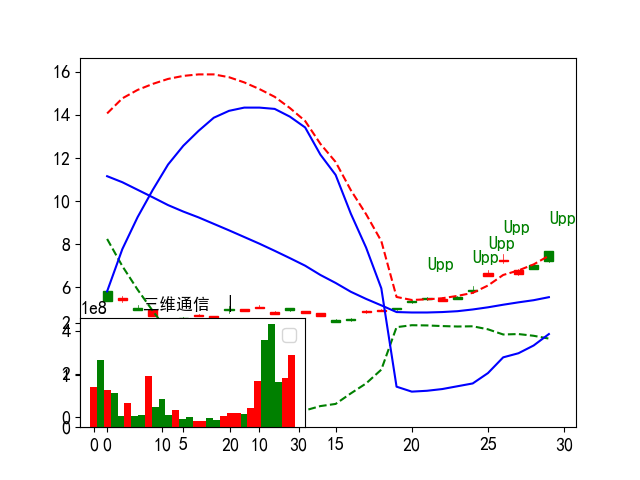

000156 1.35
xratio:0.06 ra_diff:1.35


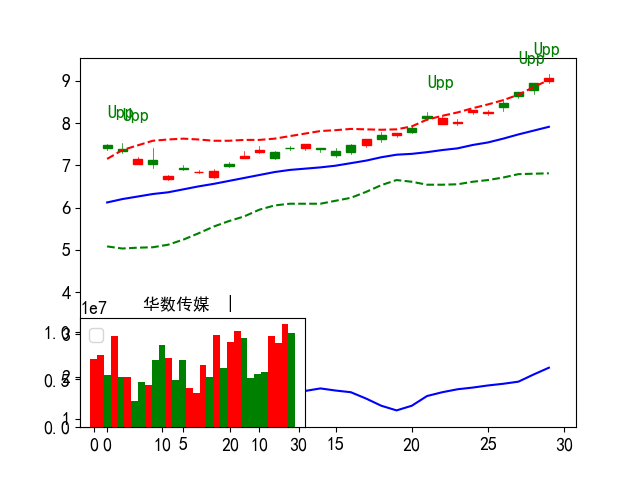

600198 1.4
xratio:0.05 ra_diff:1.4


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


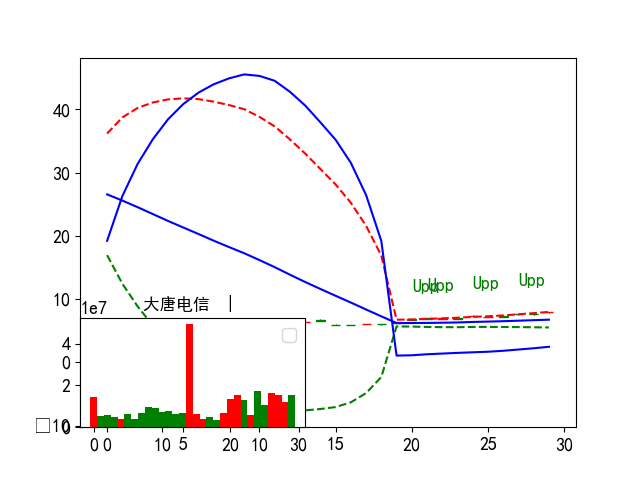

300429 1.37
xratio:0.02 ra_diff:1.37


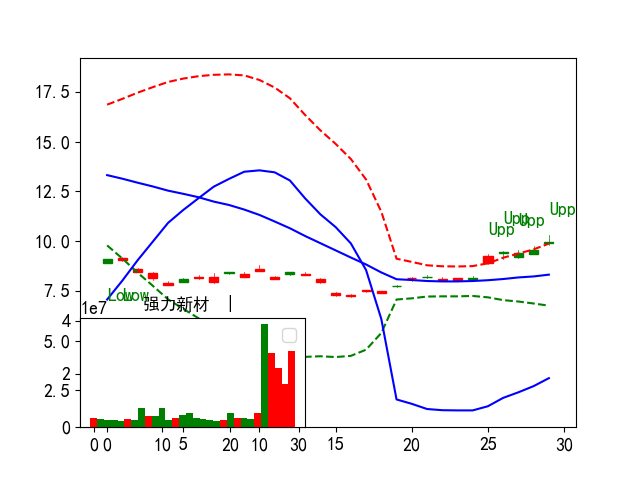

002371 1.3
xratio:-0.87 ra_diff:1.3


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


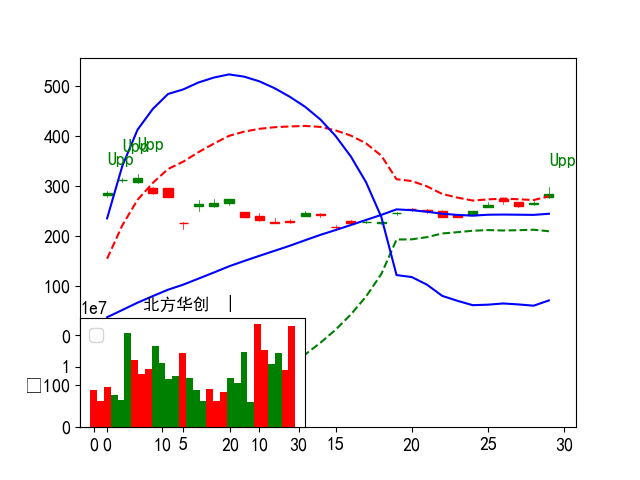

In [597]:
print("df_mask250:%s"%(len(cross_hmax_250)))
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 写入061

In [598]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [599]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [600]:
top_temp.shape
top_temp.index

(130, 33)

Index(['000021', '300964', '002558', '002602', '002605', '002777', '300002',
       '300576', '000065', '300766',
       ...
       '300730', '300302', '002624', '300303', '002115', '300223', '300168',
       '300161', '002919', '000989'],
      dtype='object', name='code', length=130)

## plt.close('all')

In [601]:
# plt.close('all')

# 写入060